In [1]:
#Gluonts Package
import gluonts

import scipy as sp
import pandas as pd
import numpy as np
import mxnet as mx
import seaborn as sns
import matplotlib.pyplot as plt
import os

from matplotlib import cm
from typing import Dict, Optional, Tuple, List

from gluonts.model.common import Tensor
from gluonts.core.component import validated
from gluonts.distribution import Distribution, DistributionOutput
from gluonts.distribution.distribution import _sample_multiple, getF, softplus
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.trainer import Trainer
from gluonts.model.canonical._estimator import MLPForecasterEstimator

#S3 Data Package
from aws_poirot_model_benchmark.anomaly_dataset import AnomalyDataset

#SPOT & DSPOT Package
from scipy.optimize import minimize
from math import log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

plt.rcParams['figure.figsize'] = (12.8, 9.6) 

# colors for plot
deep_saffron = '#FF9933'
air_force_blue = '#5D8AA8'

INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU
INFO:root:Using CPU


In [2]:
data_list = AnomalyDataset.from_s3("s3://poirot-ad-datasets/order-rate/US/data.json")
d = data_list[0]
d

AnomalyDataset object None with 1347422 data points. 

In [3]:
d[:15000].to_s3("s3://poirot-ad-datasets/order-rate/toy/US/data.json")

In [4]:
import numpy as np
np.array(d.ts).mean()

7974.844943158119

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


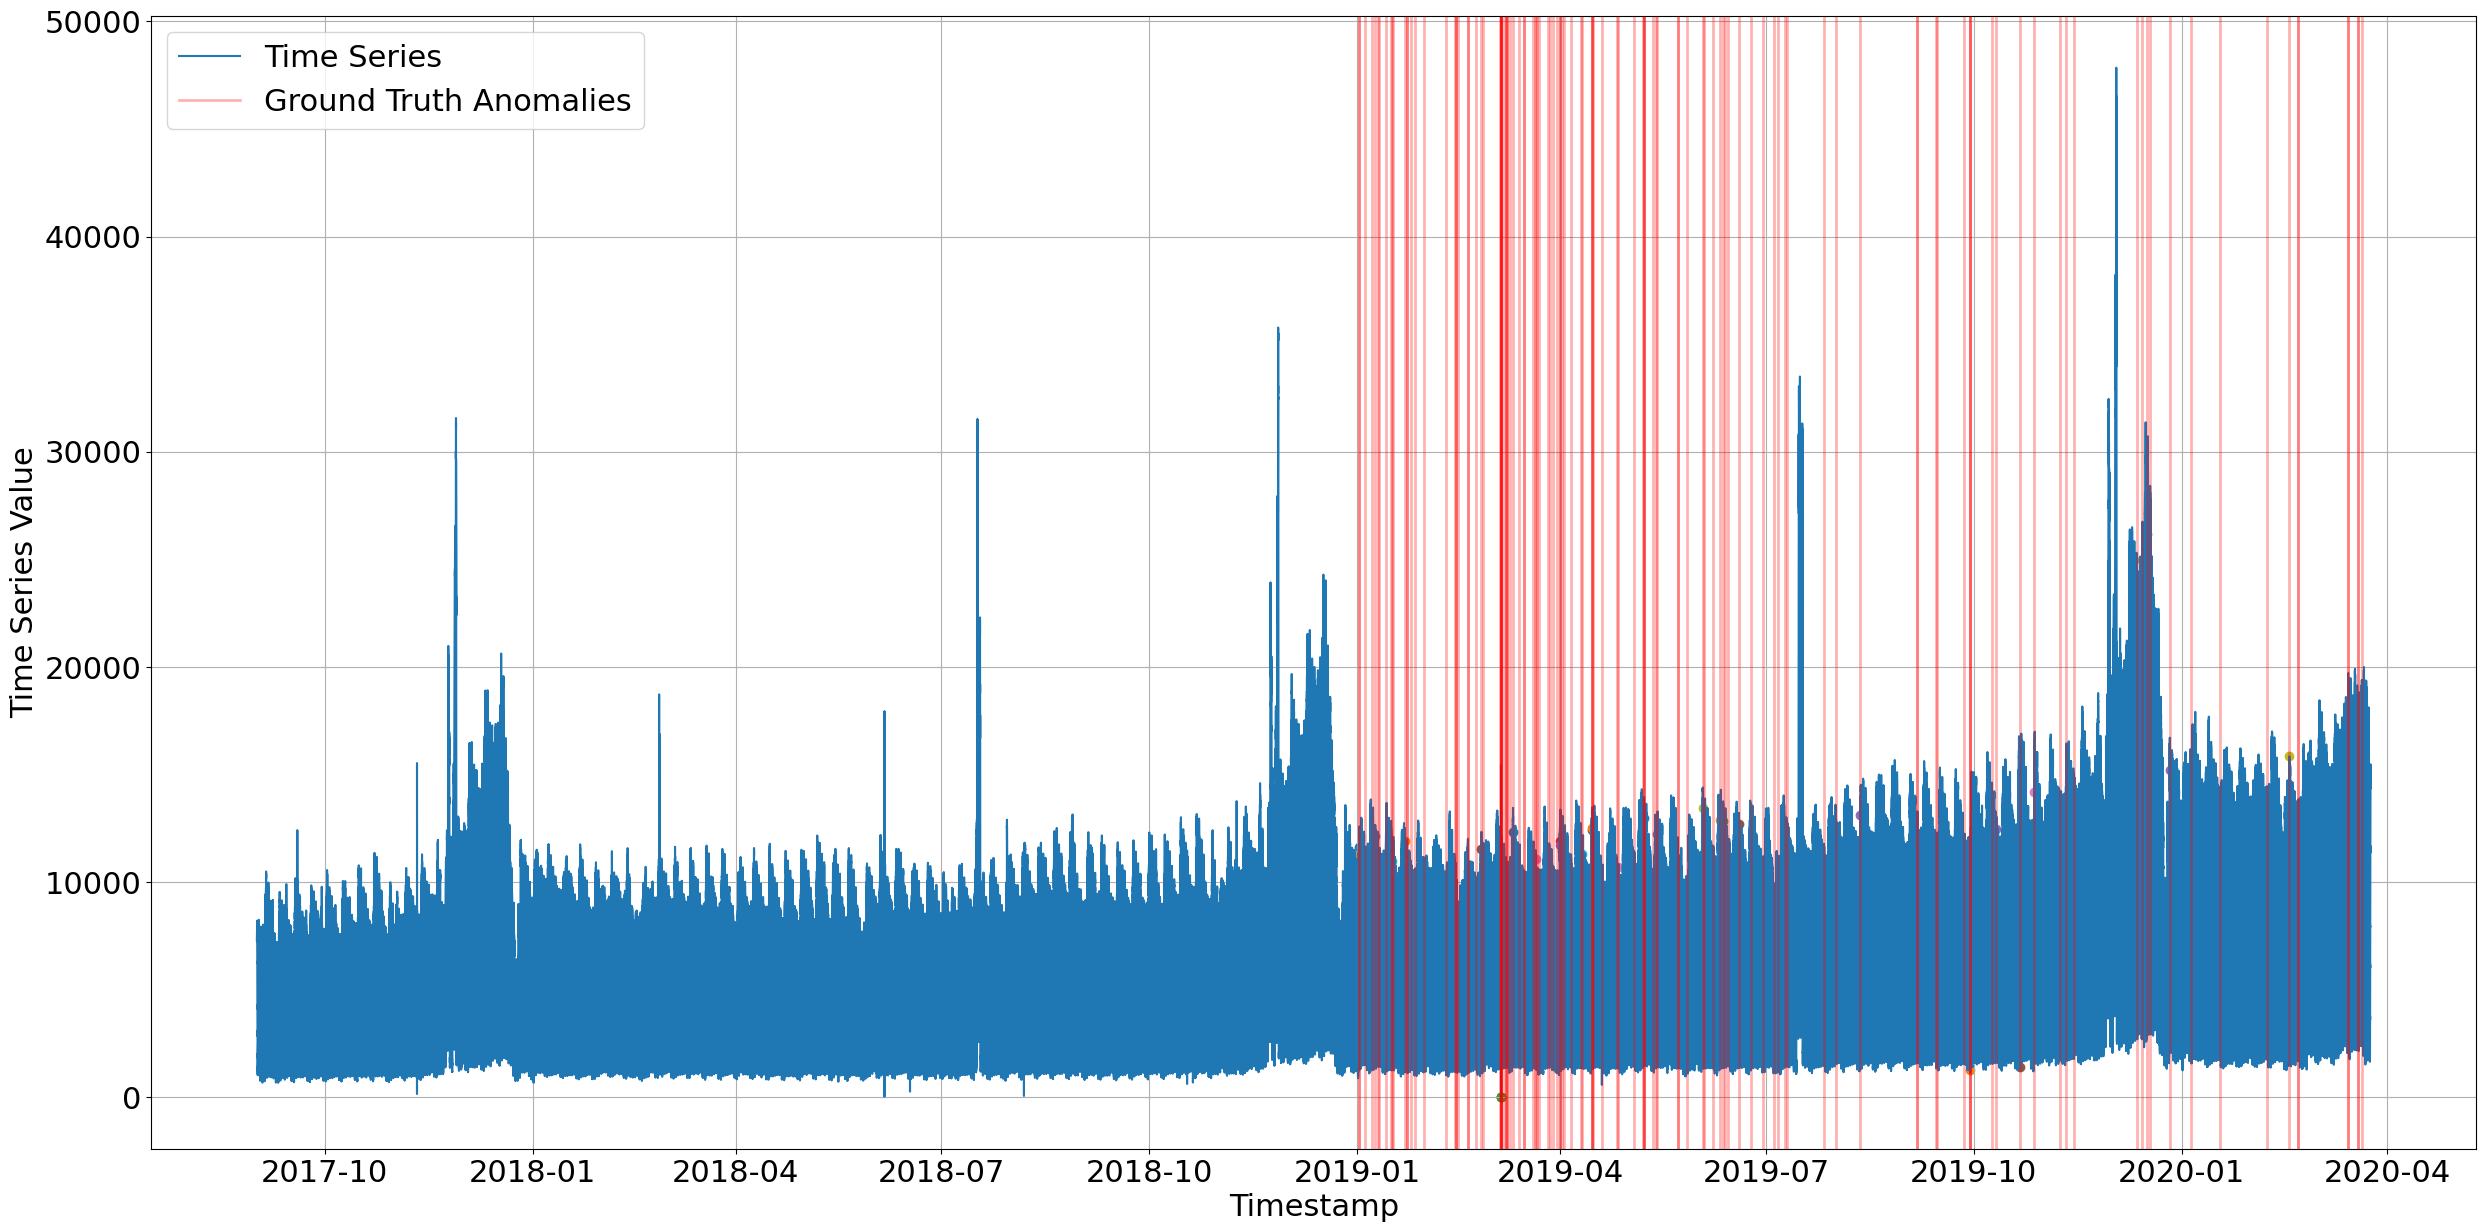

In [5]:
d.plot()

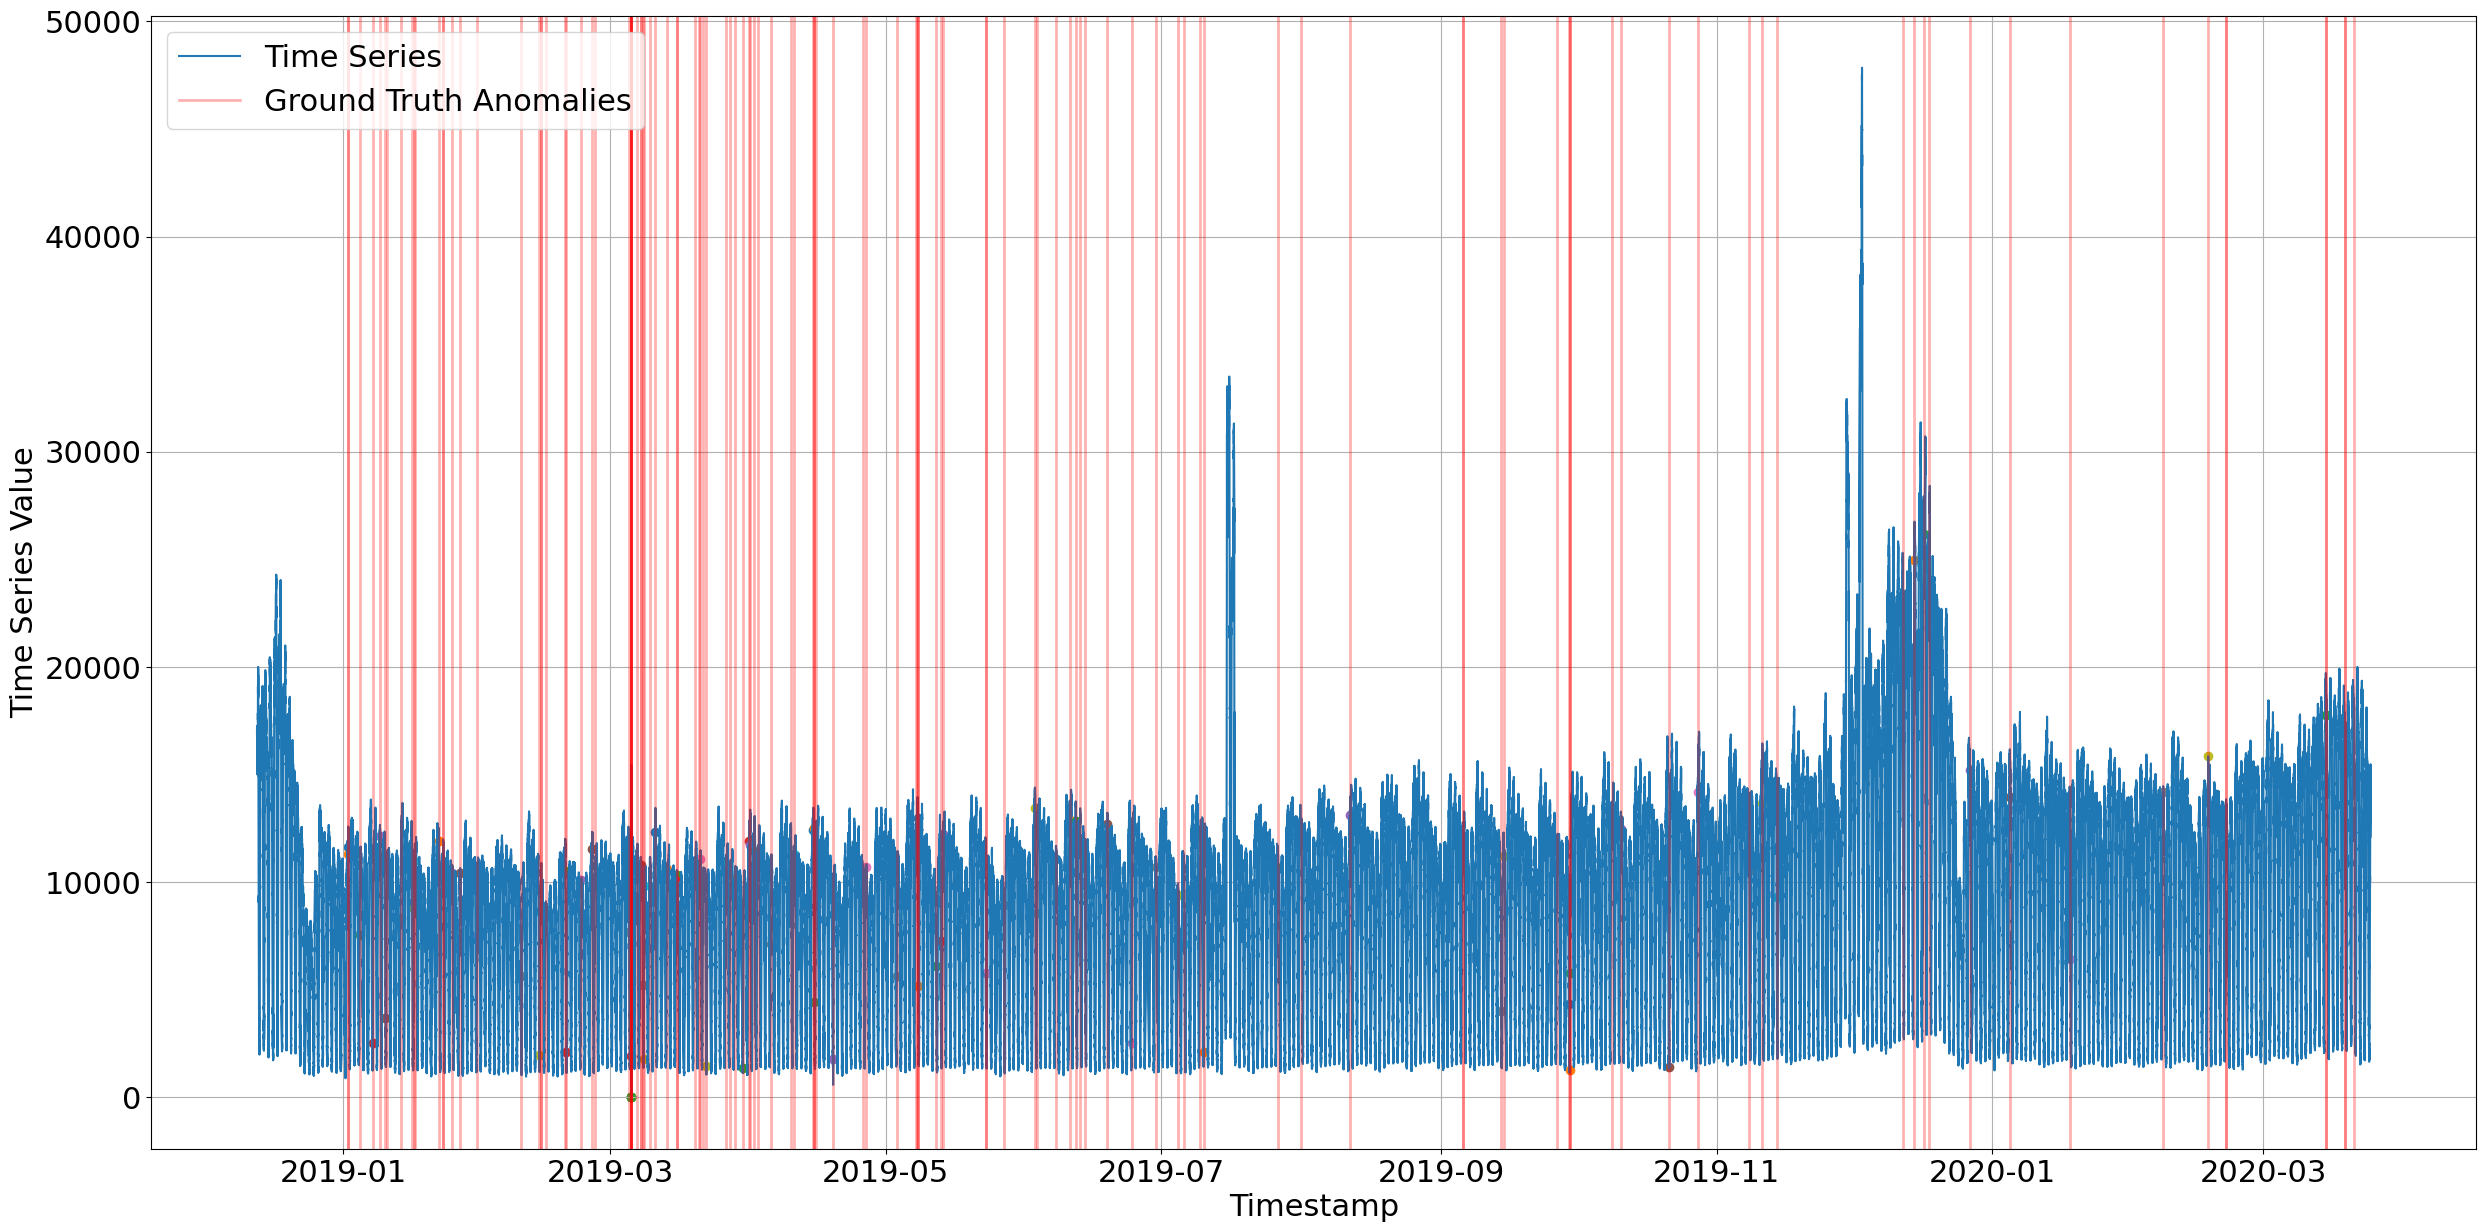

In [6]:
d[len(d)//2:].plot()

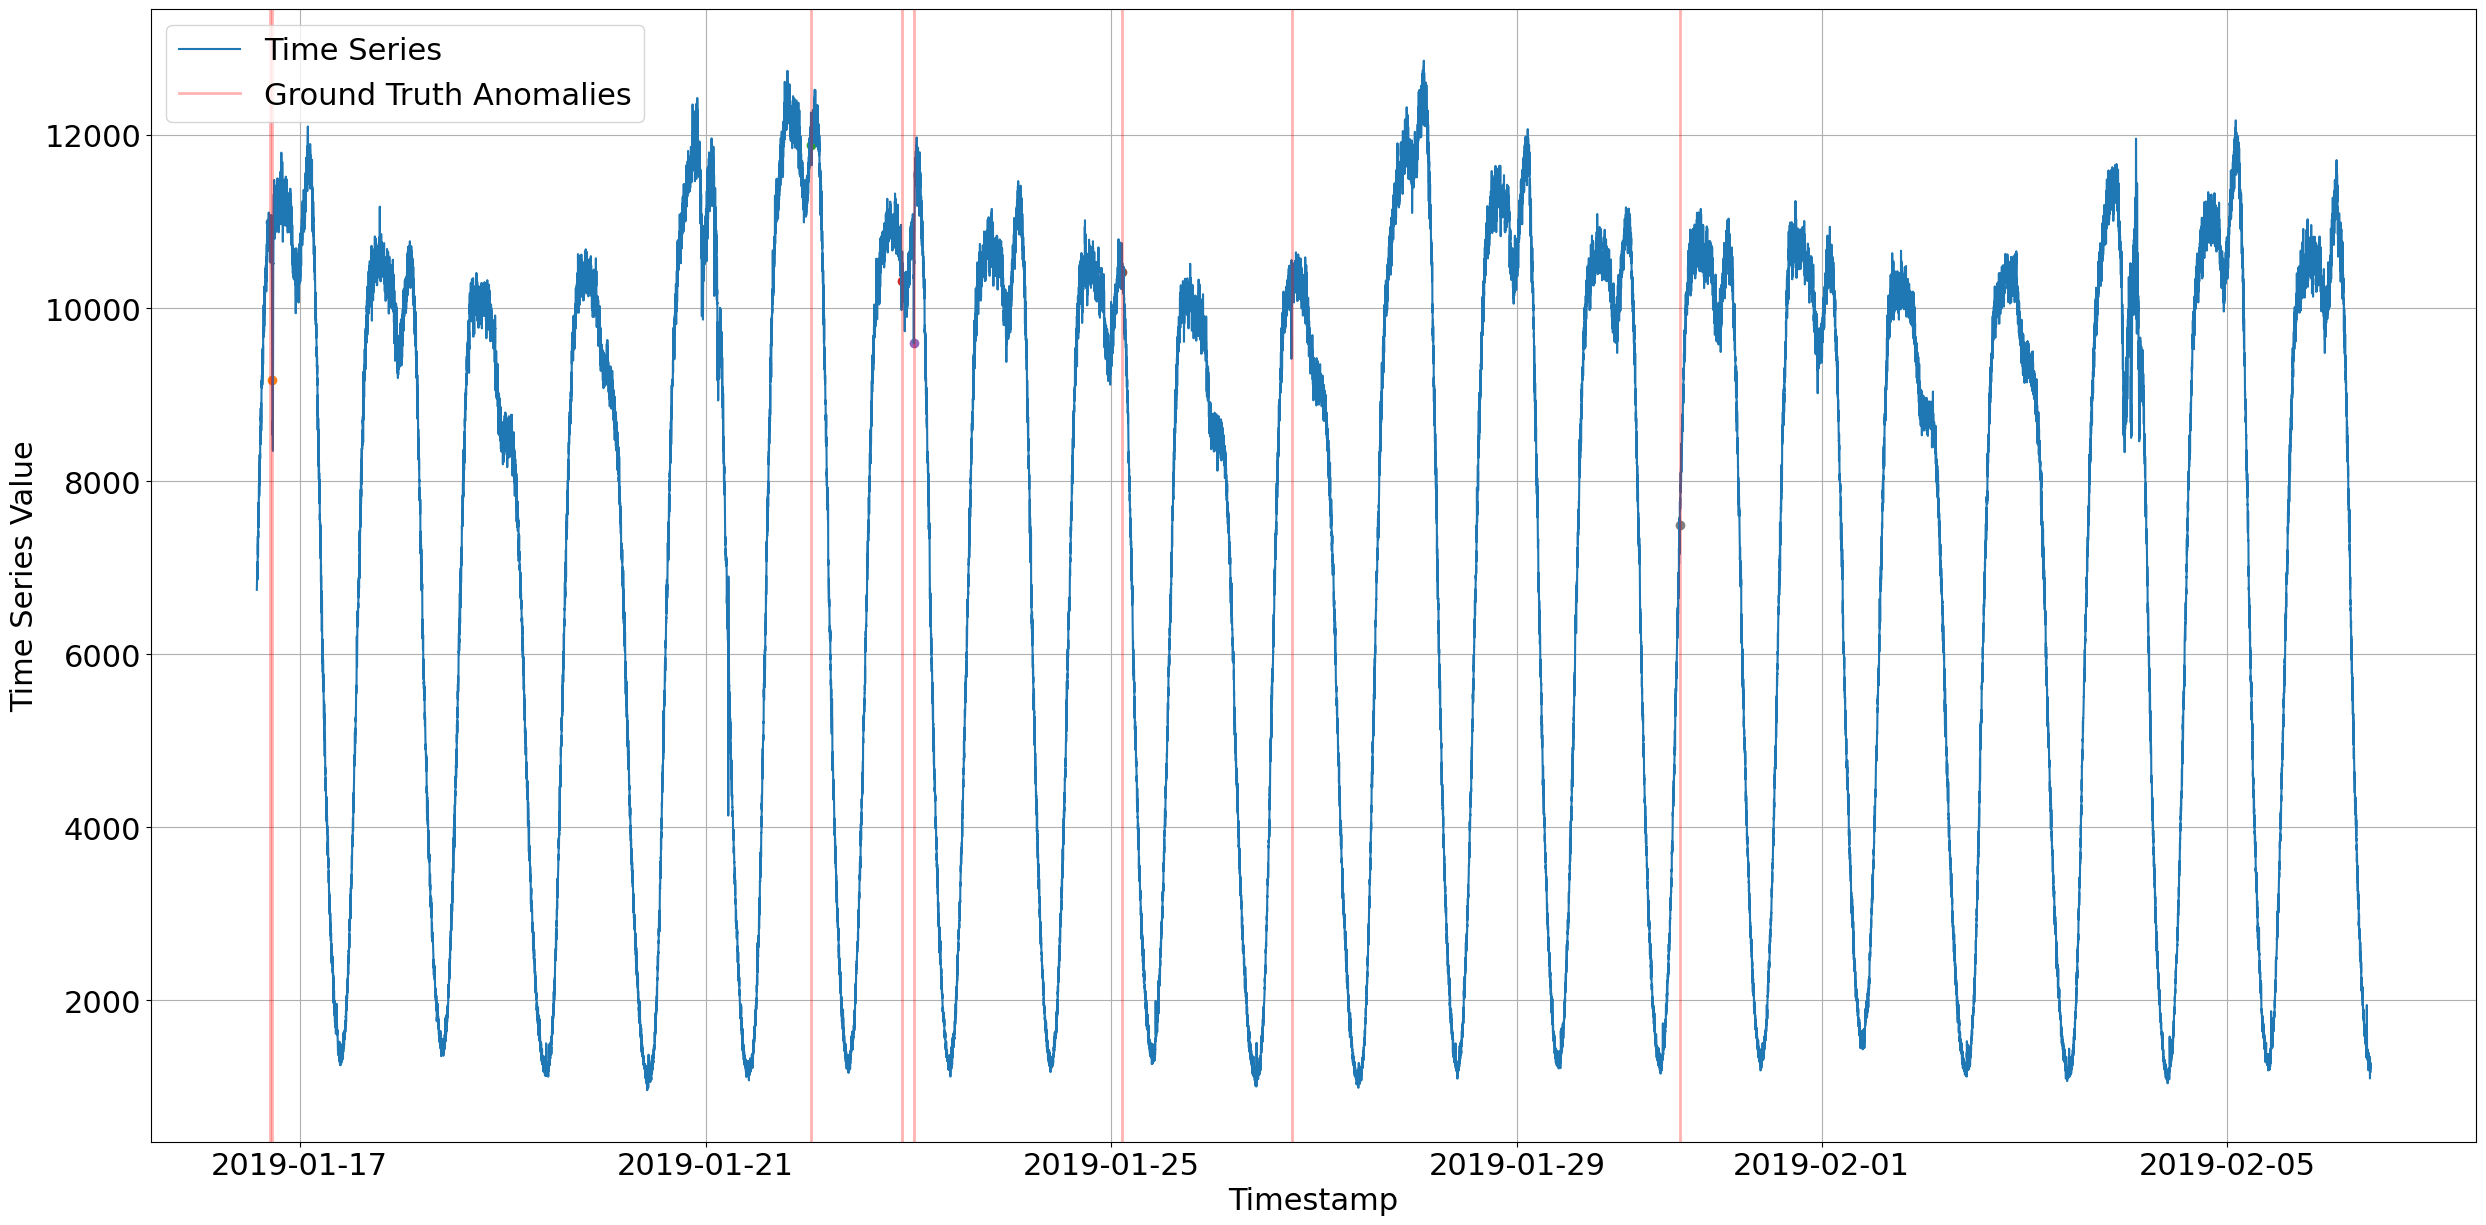

In [7]:
d[len(d)//2+50000:len(d)//2+80000].plot()

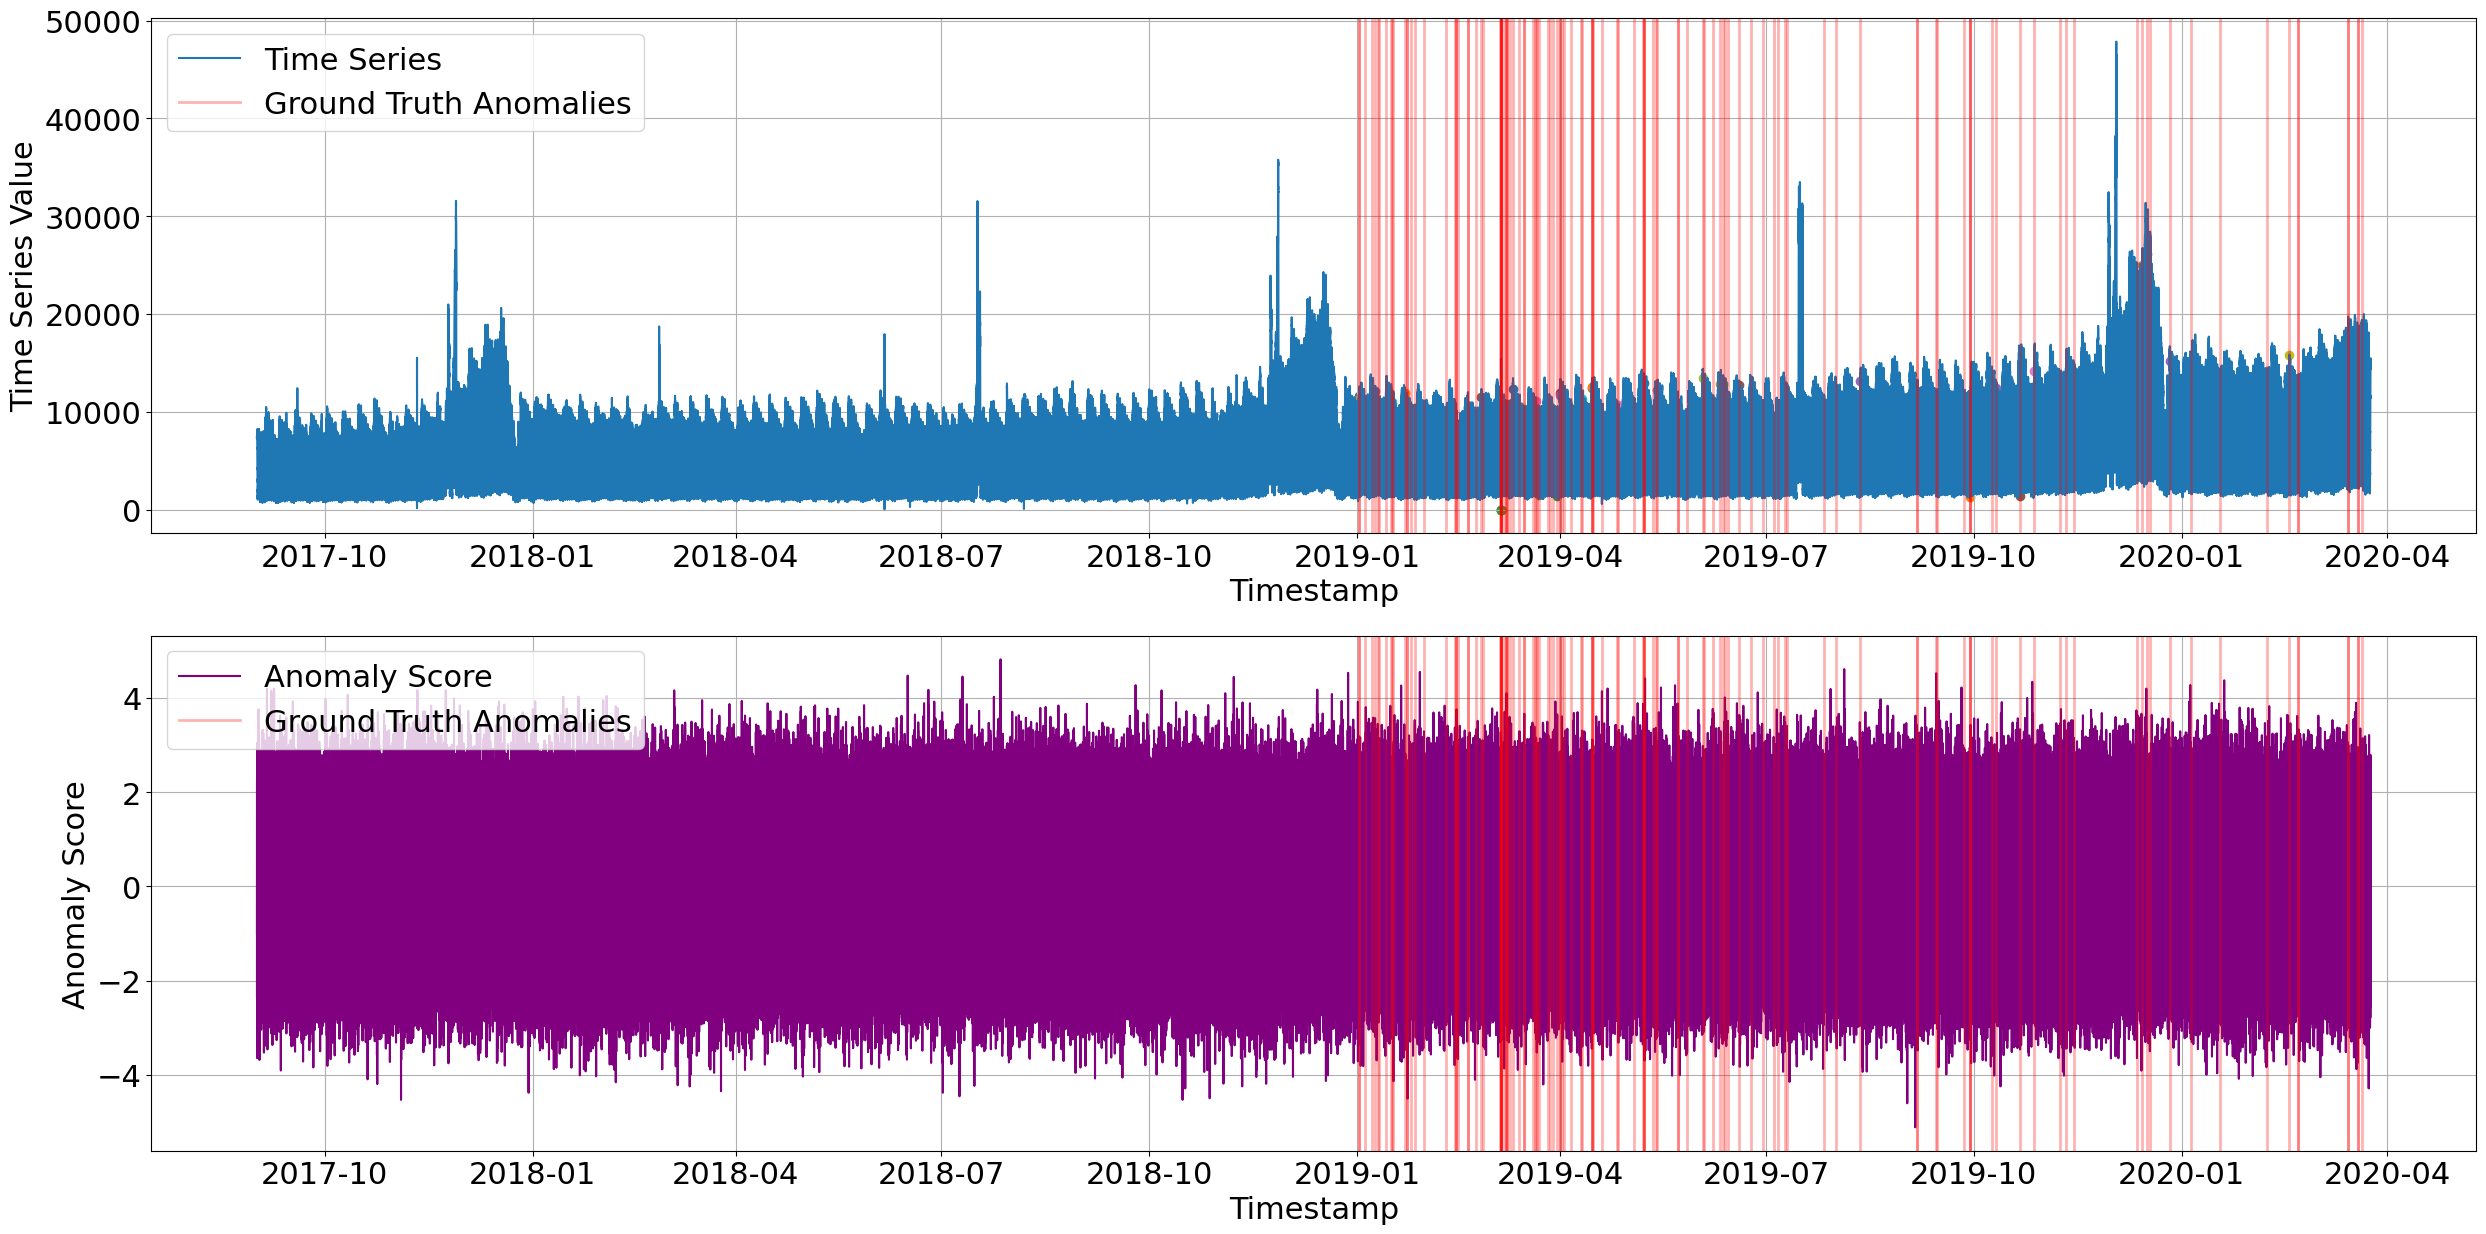

In [8]:
import numpy as np
d.anomaly_score = np.random.normal(size=len(d.ts))
d.plot()

In [9]:
# MARKET_PLACE_LIST = ["AU", "BR", "CA", "DE", "ES", "FR", "IN", "IT", "JP", "MX", "UK", "US"]
# for market in MARKET_PLACE_LIST:
#     print(market)
#     d = AnomalyDataset.from_s3(f"s3://poirot-ad-datasets/order-rate/{market}/data.json")[0]
#     ad = d.get_aggregated_dataset(aggregate_window=5)
#     ad.to_s3(f"s3://poirot-ad-datasets/order-rate/5min/{market}/data.json")

# SPOT

In [10]:
class SPOT:
    """
    This class allows to run SPOT algorithm on univariate dataset (upper-bound)
    
    Attributes
    ----------
    proba : float
        Detection level (risk), chosen by the user
        
    extreme_quantile : float
        current threshold (bound between normal and abnormal events)
        
    data : numpy.array
        stream
    
    init_data : numpy.array
        initial batch of observations (for the calibration/initialization step)
    
    init_threshold : float
        initial threshold computed during the calibration step
    
    peaks : numpy.array
        array of peaks (excesses above the initial threshold)
    
    n : int
        number of observed values
    
    Nt : int
        number of observed peaks
    """
    
    def __init__(self, q = 1e-4):
        """
        Constructor

	    Parameters
	    ----------
	    q
		    Detection level (risk)
	
	    Returns
	    ----------
    	SPOT object
        """
        self.proba = q
        self.extreme_quantile = None
        self.data = None
        self.init_data = None
        self.init_threshold = None
        self.peaks = None
        self.n = 0
        self.Nt = 0
        
    def __str__(self):
        s = ''
        s += 'Streaming Peaks-Over-Threshold Object\n'
        s += 'Detection level q = %s\n' % self.proba
        if self.data is not None:
            s += 'Data imported : Yes\n'
            s += '\t initialization  : %s values\n' % self.init_data.size
            s += '\t stream : %s values\n' % self.data.size
        else:
            s += 'Data imported : No\n'
            return s
            
        if self.n == 0:
            s += 'Algorithm initialized : No\n'
        else:
            s += 'Algorithm initialized : Yes\n'
            s += '\t initial threshold : %s\n' % self.init_threshold
            
            r = self.n-self.init_data.size
            if r > 0:
                s += 'Algorithm run : Yes\n'
                s += '\t number of observations : %s (%.2f %%)\n' % (r,100*r/self.n)
            else:
                s += '\t number of peaks  : %s\n' % self.Nt
                s += '\t extreme quantile : %s\n' % self.extreme_quantile
                s += 'Algorithm run : No\n'
        return s
    
    
    def fit(self,init_data,data):
        """
        Import data to SPOT object
        
        Parameters
	    ----------
	    init_data : list, numpy.array or pandas.Series
		    initial batch to calibrate the algorithm
            
        data : numpy.array
		    data for the run (list, np.array or pd.series)
	
        """
        if isinstance(data,list):
            self.data = np.array(data)
        elif isinstance(data,np.ndarray):
            self.data = data
        elif isinstance(data,pd.Series):
            self.data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
            
        if isinstance(init_data,list):
            self.init_data = np.array(init_data)
        elif isinstance(init_data,np.ndarray):
            self.init_data = init_data
        elif isinstance(init_data,pd.Series):
            self.init_data = init_data.values
        elif isinstance(init_data,int):
            self.init_data = self.data[:init_data]
            self.data = self.data[init_data:]
        elif isinstance(init_data,float) & (init_data<1) & (init_data>0):
            r = int(init_data*data.size)
            self.init_data = self.data[:r]
            self.data = self.data[r:]
        else:
            print('The initial data cannot be set')
            return
        
    def add(self,data):
        """
        This function allows to append data to the already fitted data
        
        Parameters
	    ----------
	    data : list, numpy.array, pandas.Series
		    data to append
        """
        if isinstance(data,list):
            data = np.array(data)
        elif isinstance(data,np.ndarray):
            data = data
        elif isinstance(data,pd.Series):
            data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
        
        self.data = np.append(self.data,data)
        return
    
    def initialize(self, numObser, verbose = True):
        """
        Run the calibration (initialization) step
        
        Parameters
	    ----------
	    verbose : bool
		    (default = True) If True, gives details about the batch initialization
        """
        n_init = self.init_data.size
        
        S = np.sort(self.init_data)     # we sort X to get the empirical quantile
        self.init_threshold = S[int(0.98*n_init)] # t is fixed for the whole algorithm

        # initial peaks
        self.peaks = self.init_data[self.init_data>self.init_threshold]-self.init_threshold 
        self.Nt = self.peaks.size
        self.n = n_init
        
        if verbose:
            print('Initial threshold : %s' % self.init_threshold)
            print('Number of peaks : %s' % self.Nt)
            print('The ratio number of peaks over number of observations : ', float(self.Nt)/float(numObser))
            print('Grimshaw maximum log-likelihood estimation ... ', end = '')
            
        g,s,l = self._grimshaw()
        self.extreme_quantile = self._quantile(g,s)
        
        if verbose:
            print('[done]')
            print('\t'+chr(0x03B3) + ' = ' + str(g))
            print('\t'+chr(0x03C3) + ' = ' + str(s))
            print('\tL = ' + str(l))
            print('Extreme quantile (probability = %s): %s' % (self.proba,self.extreme_quantile))
        
        return 
    
    
    
    
    def _rootsFinder(fun,jac,bounds,npoints,method):
        """
        Find possible roots of a scalar function
        
        Parameters
        ----------
        fun : function
		    scalar function 
        jac : function
            first order derivative of the function  
        bounds : tuple
            (min,max) interval for the roots search    
        npoints : int
            maximum number of roots to output      
        method : str
            'regular' : regular sample of the search interval, 'random' : uniform (distribution) sample of the search interval
        
        Returns
        ----------
        numpy.array
            possible roots of the function
        """
        if method == 'regular':
            step = (bounds[1]-bounds[0])/(npoints+1)
            X0 = np.arange(bounds[0]+step,bounds[1],step)
        elif method == 'random':
            X0 = np.random.uniform(bounds[0],bounds[1],npoints)
        
        def objFun(X,f,jac):
            g = 0
            j = np.zeros(X.shape)
            i = 0
            for x in X:
                fx = f(x)
                g = g+fx**2
                j[i] = 2*fx*jac(x)
                i = i+1
            return g,j
        
        opt = minimize(lambda X:objFun(X,fun,jac), X0, 
                       method='L-BFGS-B', 
                       jac=True, bounds=[bounds]*len(X0))
        
        X = opt.x
        np.round(X,decimals = 5)
        return np.unique(X)
    
    
    def _log_likelihood(Y,gamma,sigma):
        """
        Compute the log-likelihood for the Generalized Pareto Distribution (μ=0)
        
        Parameters
        ----------
        Y : numpy.array
		    observations
        gamma : float
            GPD index parameter
        sigma : float
            GPD scale parameter (>0)   

        Returns
        ----------
        float
            log-likelihood of the sample Y to be drawn from a GPD(γ,σ,μ=0)
        """
        n = Y.size
        if gamma != 0:
            tau = gamma/sigma
            L = -n * log(sigma) - ( 1 + (1/gamma) ) * ( np.log(1+tau*Y) ).sum()
        else:
            L = n * ( 1 + log(Y.mean()) )
        return L


    def _grimshaw(self,epsilon = 1e-8, n_points = 10):
        """
        Compute the GPD parameters estimation with the Grimshaw's trick
        
        Parameters
        ----------
        epsilon : float
		    numerical parameter to perform (default : 1e-8)
        n_points : int
            maximum number of candidates for maximum likelihood (default : 10)

        Returns
        ----------
        gamma_best,sigma_best,ll_best
            gamma estimates, sigma estimates and corresponding log-likelihood
        """
        def u(s):
            return 1 + np.log(s).mean()
            
        def v(s):
            return np.mean(1/s)
        
        def w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            return us*vs-1
        
        def jac_w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            jac_us = (1/t)*(1-vs)
            jac_vs = (1/t)*(-vs+np.mean(1/s**2))
            return us*jac_vs+vs*jac_us
            
    
        Ym = self.peaks.min()
        YM = self.peaks.max()
        Ymean = self.peaks.mean()
        
        
        a = -1/YM
        if abs(a)<2*epsilon:
            epsilon = abs(a)/n_points
        
        a = a + epsilon
        b = 2*(Ymean-Ym)/(Ymean*Ym)
        c = 2*(Ymean-Ym)/(Ym**2)
    
        # We look for possible roots
        left_zeros = SPOT._rootsFinder(lambda t: w(self.peaks,t),
                                 lambda t: jac_w(self.peaks,t),
                                 (a+epsilon,-epsilon),
                                 n_points,'regular')
        
        right_zeros = SPOT._rootsFinder(lambda t: w(self.peaks,t),
                                  lambda t: jac_w(self.peaks,t),
                                  (b,c),
                                  n_points,'regular')
    
        # all the possible roots
        zeros = np.concatenate((left_zeros,right_zeros))
        
        # 0 is always a solution so we initialize with it
        gamma_best = 0
        sigma_best = Ymean
        ll_best = SPOT._log_likelihood(self.peaks,gamma_best,sigma_best)
        
        # we look for better candidates
        for z in zeros:
            gamma = u(1+z*self.peaks)-1
            sigma = gamma/z
            ll = SPOT._log_likelihood(self.peaks,gamma,sigma)
            if ll>ll_best:
                gamma_best = gamma
                sigma_best = sigma
                ll_best = ll
    
        return gamma_best,sigma_best,ll_best

    

    def _quantile(self,gamma,sigma):
        """
        Compute the quantile at level 1-q
        
        Parameters
        ----------
        gamma : float
		    GPD parameter
        sigma : float
            GPD parameter

        Returns
        ----------
        float
            quantile at level 1-q for the GPD(γ,σ,μ=0)
        """
        r = self.n * self.proba / self.Nt
        if gamma != 0:
            return self.init_threshold + (sigma/gamma)*(pow(r,-gamma)-1)
        else:
            return self.init_threshold - sigma*log(r)

        
    def run(self, with_alarm = True):
        """
        Run SPOT on the stream
        
        Parameters
        ----------
        with_alarm : bool
		    (default = True) If False, SPOT will adapt the threshold assuming \
            there is no abnormal values


        Returns
        ----------
        dict
            keys : 'thresholds' and 'alarms'
            
            'thresholds' contains the extreme quantiles and 'alarms' contains \
            the indexes of the values which have triggered alarms
            
        """
        if (self.n>self.init_data.size):
            print('Warning : the algorithm seems to have already been run, you \
            should initialize before running again')
            return {}
        
        # list of the thresholds
        th = []
        alarm = []
        # Loop over the stream
        for i in tqdm.tqdm(range(self.data.size)):
    
            # If the observed value exceeds the current threshold (alarm case)
            if self.data[i]>self.extreme_quantile:
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks = np.append(self.peaks,self.data[i]-self.init_threshold)
                    self.Nt += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw()
                    self.extreme_quantile = self._quantile(g,s)

            # case where the value exceeds the initial threshold but not the alarm ones
            elif self.data[i]>self.init_threshold:
                    # we add it in the peaks
                    self.peaks = np.append(self.peaks,self.data[i]-self.init_threshold)
                    self.Nt += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw()
                    self.extreme_quantile = self._quantile(g,s)
            else:
                self.n += 1

                
            th.append(self.extreme_quantile) # thresholds record
        
        return {'thresholds' : th, 'alarms': alarm}
    

    def plot(self,run_results,with_alarm = True):
        """
        Plot the results of given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()
        
        ts_fig, = plt.plot(x,self.data,color=air_force_blue)
        fig = [ts_fig]
        
        if 'thresholds' in K:
            th = run_results['thresholds']
            th_fig, = plt.plot(x,th,color=deep_saffron,lw=2,ls='dashed')
            fig.append(th_fig)
        
        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            al_fig = plt.scatter(alarm,self.data[alarm],color='red')
            fig.append(al_fig)
            
        plt.xlim((0,self.data.size))

        
        return fig
    
    def plotErrorRate(self,zth,run_results,with_alarm = True):
        """
        Plot the error rate of given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()
        fig = []
        errorRate = []
        
        if 'thresholds' in K:
            th = run_results['thresholds']
            for i in range(len(th)):
                errorRate.append(abs(th[i]-zth/zth))
            th_fig, = plt.plot(x,errorRate,color=air_force_blue)
            fig.append(th_fig)
            
        plt.xlim((0,self.data.size))
        
        return fig
    def calPosiRate(self,run_results,with_alarm = True):
        """
        Plot the error rate of given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        K = run_results.keys()
        truePosi = 0
        falsePosi = 0
        alarmNum = 0
        notExtreme = 0
        
        if 'thresholds' in K:
            th = run_results['thresholds']
            for i in range(len(th)):
                if self.data[i] > th[i]:
                    truePosi = truePosi + 1
                    if self.data[i] <= self.extreme_quantile:
                        notExtreme = notExtreme + 1
                else:
                    falsePosi = falsePosi + 1
        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            alarmNum = len(alarm)
        
        return truePosi, falsePosi, alarmNum, notExtreme

# biSPOT

In [11]:
class biSPOT:
    """
    This class allows to run biSPOT algorithm on univariate dataset (upper and lower bounds)
    
    Attributes
    ----------
    proba : float
        Detection level (risk), chosen by the user
        
    extreme_quantile : float
        current threshold (bound between normal and abnormal events)
        
    data : numpy.array
        stream
    
    init_data : numpy.array
        initial batch of observations (for the calibration/initialization step)
    
    init_threshold : float
        initial threshold computed during the calibration step
    
    peaks : numpy.array
        array of peaks (excesses above the initial threshold)
    
    n : int
        number of observed values
    
    Nt : int
        number of observed peaks
    """
    def __init__(self, q = 1e-4):
        """
        Constructor

	    Parameters
	    ----------
	    q
		    Detection level (risk)
	
	    Returns
	    ----------
        biSPOT object
        """
        self.proba = q
        self.data = None
        self.init_data = None
        self.n = 0
        nonedict =  {'up':None,'down':None}
        
        self.extreme_quantile = dict.copy(nonedict)
        self.init_threshold = dict.copy(nonedict)
        self.peaks = dict.copy(nonedict)
        self.gamma = dict.copy(nonedict)
        self.sigma = dict.copy(nonedict)
        self.Nt = {'up':0,'down':0}
        
        
    def __str__(self):
        s = ''
        s += 'Streaming Peaks-Over-Threshold Object\n'
        s += 'Detection level q = %s\n' % self.proba
        if self.data is not None:
            s += 'Data imported : Yes\n'
            s += '\t initialization  : %s values\n' % self.init_data.size
            s += '\t stream : %s values\n' % self.data.size
        else:
            s += 'Data imported : No\n'
            return s
            
        if self.n == 0:
            s += 'Algorithm initialized : No\n'
        else:
            s += 'Algorithm initialized : Yes\n'
            s += '\t initial threshold : %s\n' % self.init_threshold
            
            r = self.n-self.init_data.size
            if r > 0:
                s += 'Algorithm run : Yes\n'
                s += '\t number of observations : %s (%.2f %%)\n' % (r,100*r/self.n)
                s += '\t triggered alarms : %s (%.2f %%)\n' % (len(self.alarm),100*len(self.alarm)/self.n)
            else:
                s += '\t number of peaks  : %s\n' % self.Nt
                s += '\t upper extreme quantile : %s\n' % self.extreme_quantile['up']
                s += '\t lower extreme quantile : %s\n' % self.extreme_quantile['down']
                s += 'Algorithm run : No\n'
        return s
    
    
    def fit(self,init_data,data):
        """
        Import data to biSPOT object
        
        Parameters
	    ----------
	    init_data : list, numpy.array or pandas.Series
		    initial batch to calibrate the algorithm ()
            
        data : numpy.array
		    data for the run (list, np.array or pd.series)
	
        """
        if isinstance(data,list):
            self.data = np.array(data)
        elif isinstance(data,np.ndarray):
            self.data = data
        elif isinstance(data,pd.Series):
            self.data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
            
        if isinstance(init_data,list):
            self.init_data = np.array(init_data)
        elif isinstance(init_data,np.ndarray):
            self.init_data = init_data
        elif isinstance(init_data,pd.Series):
            self.init_data = init_data.values
        elif isinstance(init_data,int):
            self.init_data = self.data[:init_data]
            self.data = self.data[init_data:]
        elif isinstance(init_data,float) & (init_data<1) & (init_data>0):
            r = int(init_data*data.size)
            self.init_data = self.data[:r]
            self.data = self.data[r:]
        else:
            print('The initial data cannot be set')
            return
        
    def add(self,data):
        """
        This function allows to append data to the already fitted data
        
        Parameters
	    ----------
	    data : list, numpy.array, pandas.Series
		    data to append
        """
        if isinstance(data,list):
            data = np.array(data)
        elif isinstance(data,np.ndarray):
            data = data
        elif isinstance(data,pd.Series):
            data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
        
        self.data = np.append(self.data,data)
        return

    def initialize(self, numObser, verbose = True):
        """
        Run the calibration (initialization) step
        
        Parameters
	    ----------
	    verbose : bool
		    (default = True) If True, gives details about the batch initialization
        """
        n_init = self.init_data.size
        
        S = np.sort(self.init_data)     # we sort X to get the empirical quantile
        self.init_threshold['up'] = S[int(0.98*n_init)] # t is fixed for the whole algorithm
        self.init_threshold['down'] = S[int(0.02*n_init)] # t is fixed for the whole algorithm

        # initial peaks
        self.peaks['up'] = self.init_data[self.init_data>self.init_threshold['up']]-self.init_threshold['up']
        self.peaks['down'] = -(self.init_data[self.init_data<self.init_threshold['down']]-self.init_threshold['down'])
        self.Nt['up'] = self.peaks['up'].size
        self.Nt['down'] = self.peaks['down'].size
        self.n = n_init
        
        if verbose:
            print('Initial threshold : %s' % self.init_threshold)
            print('Number of peaks : %s' % self.Nt)
            print('The ratio number of peaks over number of observations : ', float(self.Nt['up']+self.Nt['down'])/float(numObser))
            print('Grimshaw maximum log-likelihood estimation ... ', end = '')
            
        l = {'up':None,'down':None}
        for side in ['up','down']:
            g,s,l[side] = self._grimshaw(side)
            self.extreme_quantile[side] = self._quantile(side,g,s)
            self.gamma[side] = g
            self.sigma[side] = s
        
        ltab = 20
        form = ('\t'+'%20s' + '%20.2f' + '%20.2f')
        if verbose:
            print('[done]')
            print('\t' + 'Parameters'.rjust(ltab) + 'Upper'.rjust(ltab) + 'Lower'.rjust(ltab))
            print('\t' + '-'*ltab*3)
            print(form % (chr(0x03B3),self.gamma['up'],self.gamma['down']))
            print(form % (chr(0x03C3),self.sigma['up'],self.sigma['down']))
            print(form % ('likelihood',l['up'],l['down']))
            print(form % ('Extreme quantile',self.extreme_quantile['up'],self.extreme_quantile['down']))
            print('\t' + '-'*ltab*3)
        return 
    
    
    
    
    def _rootsFinder(fun,jac,bounds,npoints,method):
        """
        Find possible roots of a scalar function
        
        Parameters
        ----------
        fun : function
		    scalar function 
        jac : function
            first order derivative of the function  
        bounds : tuple
            (min,max) interval for the roots search    
        npoints : int
            maximum number of roots to output      
        method : str
            'regular' : regular sample of the search interval, 'random' : uniform (distribution) sample of the search interval
        
        Returns
        ----------
        numpy.array
            possible roots of the function
        """
        if method == 'regular':
            step = (bounds[1]-bounds[0])/(npoints+1)
            X0 = np.arange(bounds[0]+step,bounds[1],step)
        elif method == 'random':
            X0 = np.random.uniform(bounds[0],bounds[1],npoints)
        
        def objFun(X,f,jac):
            g = 0
            j = np.zeros(X.shape)
            i = 0
            for x in X:
                fx = f(x)
                g = g+fx**2
                j[i] = 2*fx*jac(x)
                i = i+1
            return g,j
        opt = minimize(lambda X:objFun(X,fun,jac), X0, 
                       method='L-BFGS-B', 
                       jac=True, bounds=[bounds]*len(X0))
        
        X = opt.x
        np.round(X,decimals = 5)
        return np.unique(X)
    
    
    def _log_likelihood(Y,gamma,sigma):
        """
        Compute the log-likelihood for the Generalized Pareto Distribution (μ=0)
        
        Parameters
        ----------
        Y : numpy.array
		    observations
        gamma : float
            GPD index parameter
        sigma : float
            GPD scale parameter (>0)   

        Returns
        ----------
        float
            log-likelihood of the sample Y to be drawn from a GPD(γ,σ,μ=0)
        """
        n = Y.size
        if gamma != 0:
            tau = gamma/sigma
            L = -n * log(sigma) - ( 1 + (1/gamma) ) * ( np.log(1+tau*Y) ).sum()
        else:
            L = n * ( 1 + log(Y.mean()) )
        return L


    def _grimshaw(self,side,epsilon = 1e-8, n_points = 10):
        """
        Compute the GPD parameters estimation with the Grimshaw's trick
        
        Parameters
        ----------
        epsilon : float
		    numerical parameter to perform (default : 1e-8)
        n_points : int
            maximum number of candidates for maximum likelihood (default : 10)

        Returns
        ----------
        gamma_best,sigma_best,ll_best
            gamma estimates, sigma estimates and corresponding log-likelihood
        """
        def u(s):
            return 1 + np.log(s).mean()
            
        def v(s):
            return np.mean(1/s)
        
        def w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            return us*vs-1
        
        def jac_w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            jac_us = (1/t)*(1-vs)
            jac_vs = (1/t)*(-vs+np.mean(1/s**2))
            return us*jac_vs+vs*jac_us
            
    
        Ym = self.peaks[side].min()
        YM = self.peaks[side].max()
        Ymean = self.peaks[side].mean()
        
        
        a = -1/YM
        if abs(a)<2*epsilon:
            epsilon = abs(a)/n_points
        
        a = a + epsilon
        b = 2*(Ymean-Ym)/(Ymean*Ym)
        c = 2*(Ymean-Ym)/(Ym**2)
    
        # We look for possible roots
        left_zeros = biSPOT._rootsFinder(lambda t: w(self.peaks[side],t),
                                 lambda t: jac_w(self.peaks[side],t),
                                 (a+epsilon,-epsilon),
                                 n_points,'regular')
        
        right_zeros = biSPOT._rootsFinder(lambda t: w(self.peaks[side],t),
                                  lambda t: jac_w(self.peaks[side],t),
                                  (b,c),
                                  n_points,'regular')
    
        # all the possible roots
        zeros = np.concatenate((left_zeros,right_zeros))
        
        # 0 is always a solution so we initialize with it
        gamma_best = 0
        sigma_best = Ymean
        ll_best = biSPOT._log_likelihood(self.peaks[side],gamma_best,sigma_best)
        
        # we look for better candidates
        for z in zeros:
            gamma = u(1+z*self.peaks[side])-1
            sigma = gamma/z
            ll = biSPOT._log_likelihood(self.peaks[side],gamma,sigma)
            if ll>ll_best:
                gamma_best = gamma
                sigma_best = sigma
                ll_best = ll
    
        return gamma_best,sigma_best,ll_best

    

    def _quantile(self,side,gamma,sigma):
        """
        Compute the quantile at level 1-q for a given side
        
        Parameters
        ----------
        side : str
            'up' or 'down'
        gamma : float
		    GPD parameter
        sigma : float
            GPD parameter

        Returns
        ----------
        float
            quantile at level 1-q for the GPD(γ,σ,μ=0)
        """
        if side == 'up':
            r = self.n * self.proba / self.Nt[side]
            if gamma != 0:
                return self.init_threshold['up'] + (sigma/gamma)*(pow(r,-gamma)-1)
            else:
                return self.init_threshold['up'] - sigma*log(r)
        elif side == 'down':
            r = self.n * self.proba / self.Nt[side]
            if gamma != 0:
                return self.init_threshold['down'] - (sigma/gamma)*(pow(r,-gamma)-1)
            else:
                return self.init_threshold['down'] + sigma*log(r)
        else:
            print('error : the side is not right')

        
    def run(self, with_alarm = True):
        """
        Run biSPOT on the stream
        
        Parameters
        ----------
        with_alarm : bool
		    (default = True) If False, SPOT will adapt the threshold assuming \
            there is no abnormal values


        Returns
        ----------
        dict
            keys : 'upper_thresholds', 'lower_thresholds' and 'alarms'
            
            '***-thresholds' contains the extreme quantiles and 'alarms' contains \
            the indexes of the values which have triggered alarms
            
        """
        if (self.n>self.init_data.size):
            print('Warning : the algorithm seems to have already been run, you \
            should initialize before running again')
            return {}
        
        # list of the thresholds
        thup = []
        thdown = []
        alarm = []
        # Loop over the stream
        for i in tqdm.tqdm(range(self.data.size)):
    
            # If the observed value exceeds the current threshold (alarm case)
            if self.data[i]>self.extreme_quantile['up'] :
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks['up'] = np.append(self.peaks['up'],self.data[i]-self.init_threshold['up'])
                    self.Nt['up'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('up')
                    self.extreme_quantile['up'] = self._quantile('up',g,s)

            # case where the value exceeds the initial threshold but not the alarm ones
            elif self.data[i]>self.init_threshold['up']:
                    # we add it in the peaks
                    self.peaks['up'] = np.append(self.peaks['up'],self.data[i]-self.init_threshold['up'])
                    self.Nt['up'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('up')
                    self.extreme_quantile['up'] = self._quantile('up',g,s)
                    
            elif self.data[i]<self.extreme_quantile['down'] :
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks['down'] = np.append(self.peaks['down'],-(self.data[i]-self.init_threshold['down']))
                    self.Nt['down'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('down')
                    self.extreme_quantile['down'] = self._quantile('down',g,s)

            # case where the value exceeds the initial threshold but not the alarm ones
            elif self.data[i]<self.init_threshold['down']:
                    # we add it in the peaks
                    self.peaks['down'] = np.append(self.peaks['down'],-(self.data[i]-self.init_threshold['down']))
                    self.Nt['down'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('down')
                    self.extreme_quantile['down'] = self._quantile('down',g,s)
            else:
                self.n += 1

                
            thup.append(self.extreme_quantile['up']) # thresholds record
            thdown.append(self.extreme_quantile['down']) # thresholds record
        
        return {'upper_thresholds' : thup,'lower_thresholds' : thdown, 'alarms': alarm}
    
    def plot(self,run_results,with_alarm = True):
        """
        Plot the results of given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()
        
        ts_fig, = plt.plot(x,self.data,color=air_force_blue)
        fig = [ts_fig]
        
        if 'upper_thresholds' in K:
            thup = run_results['upper_thresholds']
            uth_fig, = plt.plot(x,thup,color=deep_saffron,lw=2,ls='dashed')
            fig.append(uth_fig)
            
        if 'lower_thresholds' in K:
            thdown = run_results['lower_thresholds']
            lth_fig, = plt.plot(x,thdown,color=deep_saffron,lw=2,ls='dashed')
            fig.append(lth_fig)
        
        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            al_fig = plt.scatter(alarm,self.data[alarm],color='red')
            fig.append(al_fig)
            
        plt.xlim((0,self.data.size))

        
        return fig

# WITH DRIFT

In [12]:
def backMean(X,d):
    M = []
    w = X[:d].sum()
    M.append(w/d)
    for i in range(d,len(X)):
        w = w - X[i-d] + X[i]
        M.append(w/d)
    return np.array(M)

# DSPOT

In [13]:
class dSPOT:
    """
    This class allows to run DSPOT algorithm on univariate dataset (upper-bound)
    
    Attributes
    ----------
    proba : float
        Detection level (risk), chosen by the user
        
    depth : int
        Number of observations to compute the moving average
        
    extreme_quantile : float
        current threshold (bound between normal and abnormal events)
        
    data : numpy.array
        stream
    
    init_data : numpy.array
        initial batch of observations (for the calibration/initialization step)
    
    init_threshold : float
        initial threshold computed during the calibration step
    
    peaks : numpy.array
        array of peaks (excesses above the initial threshold)
    
    n : int
        number of observed values
    
    Nt : int
        number of observed peaks
    """
    def __init__(self, q, depth):
        self.proba = q
        self.extreme_quantile = None
        self.data = None
        self.init_data = None
        self.init_threshold = None
        self.peaks = None
        self.n = 0
        self.Nt = 0
        self.depth = depth
        
    def __str__(self):
        s = ''
        s += 'Streaming Peaks-Over-Threshold Object\n'
        s += 'Detection level q = %s\n' % self.proba
        if self.data is not None:
            s += 'Data imported : Yes\n'
            s += '\t initialization  : %s values\n' % self.init_data.size
            s += '\t stream : %s values\n' % self.data.size
        else:
            s += 'Data imported : No\n'
            return s
            
        if self.n == 0:
            s += 'Algorithm initialized : No\n'
        else:
            s += 'Algorithm initialized : Yes\n'
            s += '\t initial threshold : %s\n' % self.init_threshold
            
            r = self.n-self.init_data.size
            if r > 0:
                s += 'Algorithm run : Yes\n'
                s += '\t number of observations : %s (%.2f %%)\n' % (r,100*r/self.n)
                s += '\t triggered alarms : %s (%.2f %%)\n' % (len(self.alarm),100*len(self.alarm)/self.n)
            else:
                s += '\t number of peaks  : %s\n' % self.Nt
                s += '\t extreme quantile : %s\n' % self.extreme_quantile
                s += 'Algorithm run : No\n'
        return s
    
    
    def fit(self,init_data,data):
        """
        Import data to DSPOT object
        
        Parameters
	    ----------
	    init_data : list, numpy.array or pandas.Series
		    initial batch to calibrate the algorithm
            
        data : numpy.array
		    data for the run (list, np.array or pd.series)
	
        """
        if isinstance(data,list):
            self.data = np.array(data)
        elif isinstance(data,np.ndarray):
            self.data = data
        elif isinstance(data,pd.Series):
            self.data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
            
        if isinstance(init_data,list):
            self.init_data = np.array(init_data)
        elif isinstance(init_data,np.ndarray):
            self.init_data = init_data
        elif isinstance(init_data,pd.Series):
            self.init_data = init_data.values
        elif isinstance(init_data,int):
            self.init_data = self.data[:init_data]
            self.data = self.data[init_data:]
        elif isinstance(init_data,float) & (init_data<1) & (init_data>0):
            r = int(init_data*data.size)
            self.init_data = self.data[:r]
            self.data = self.data[r:]
        else:
            print('The initial data cannot be set')
            return
        
    def add(self,data):
        """
        This function allows to append data to the already fitted data
        
        Parameters
	    ----------
	    data : list, numpy.array, pandas.Series
		    data to append
        """
        if isinstance(data,list):
            data = np.array(data)
        elif isinstance(data,np.ndarray):
            data = data
        elif isinstance(data,pd.Series):
            data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
        
        self.data = np.append(self.data,data)
        return
    
    def initialize(self, numObser, verbose = True):
        """
        Run the calibration (initialization) step
        
        Parameters
	    ----------
	    verbose : bool
		    (default = True) If True, gives details about the batch initialization
        """
        n_init = self.init_data.size - self.depth
        
        M = backMean(self.init_data,self.depth)
        T = self.init_data[self.depth:]-M[:-1] # new variable
        
        S = np.sort(T)     # we sort X to get the empirical quantile
        self.init_threshold = S[int(0.98*n_init)] # t is fixed for the whole algorithm

        # initial peaks
        self.peaks = T[T>self.init_threshold]-self.init_threshold 
        self.Nt = self.peaks.size
        self.n = n_init
        
        if verbose:
            print('Initial threshold : %s' % self.init_threshold)
            print('Number of peaks : %s' % self.Nt)
            print('The ratio number of peaks over number of observations : ', float(self.Nt)/float(numObser))
            print('Grimshaw maximum log-likelihood estimation ... ', end = '')
            
        g,s,l = self._grimshaw()
        self.extreme_quantile = self._quantile(g,s)
        
        if verbose:
            print('[done]')
            print('\t'+chr(0x03B3) + ' = ' + str(g))
            print('\t'+chr(0x03C3) + ' = ' + str(s))
            print('\tL = ' + str(l))
            print('Extreme quantile (probability = %s): %s' % (self.proba,self.extreme_quantile))
        
        return
    
    
    
    
    def _rootsFinder(fun,jac,bounds,npoints,method):
        """
        Find possible roots of a scalar function
        
        Parameters
        ----------
        fun : function
		    scalar function 
        jac : function
            first order derivative of the function  
        bounds : tuple
            (min,max) interval for the roots search    
        npoints : int
            maximum number of roots to output      
        method : str
            'regular' : regular sample of the search interval, 'random' : uniform (distribution) sample of the search interval
        
        Returns
        ----------
        numpy.array
            possible roots of the function
        """
        if method == 'regular':
            step = (bounds[1]-bounds[0])/(npoints+1)
            X0 = np.arange(bounds[0]+step,bounds[1],step)
        elif method == 'random':
            X0 = np.random.uniform(bounds[0],bounds[1],npoints)
        
        def objFun(X,f,jac):
            g = 0
            j = np.zeros(X.shape)
            i = 0
            for x in X:
                fx = f(x)
                g = g+fx**2
                j[i] = 2*fx*jac(x)
                i = i+1
            return g,j
        
        opt = minimize(lambda X:objFun(X,fun,jac), X0, 
                       method='L-BFGS-B', 
                       jac=True, bounds=[bounds]*len(X0))
        
        X = opt.x
        np.round(X,decimals = 5)
        return np.unique(X)
    
    
    def _log_likelihood(Y,gamma,sigma):
        """
        Compute the log-likelihood for the Generalized Pareto Distribution (μ=0)
        
        Parameters
        ----------
        Y : numpy.array
		    observations
        gamma : float
            GPD index parameter
        sigma : float
            GPD scale parameter (>0)   

        Returns
        ----------
        float
            log-likelihood of the sample Y to be drawn from a GPD(γ,σ,μ=0)
        """
        n = Y.size
        if gamma != 0:
            tau = gamma/sigma
            L = -n * log(sigma) - ( 1 + (1/gamma) ) * ( np.log(1+tau*Y) ).sum()
        else:
            L = n * ( 1 + log(Y.mean()) )
        return L


    def _grimshaw(self,epsilon = 1e-8, n_points = 10):
        """
        Compute the GPD parameters estimation with the Grimshaw's trick
        
        Parameters
        ----------
        epsilon : float
		    numerical parameter to perform (default : 1e-8)
        n_points : int
            maximum number of candidates for maximum likelihood (default : 10)

        Returns
        ----------
        gamma_best,sigma_best,ll_best
            gamma estimates, sigma estimates and corresponding log-likelihood
        """
        def u(s):
            return 1 + np.log(s).mean()
            
        def v(s):
            return np.mean(1/s)
        
        def w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            return us*vs-1
        
        def jac_w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            jac_us = (1/t)*(1-vs)
            jac_vs = (1/t)*(-vs+np.mean(1/s**2))
            return us*jac_vs+vs*jac_us
            
    
        Ym = self.peaks.min()
        YM = self.peaks.max()
        Ymean = self.peaks.mean()
        
        
        a = -1/YM
        if abs(a)<2*epsilon:
            epsilon = abs(a)/n_points
        
        a = a + epsilon
        b = 2*(Ymean-Ym)/(Ymean*Ym)
        c = 2*(Ymean-Ym)/(Ym**2)
    
        # We look for possible roots
        left_zeros = SPOT._rootsFinder(lambda t: w(self.peaks,t),
                                 lambda t: jac_w(self.peaks,t),
                                 (a+epsilon,-epsilon),
                                 n_points,'regular')
        
        right_zeros = SPOT._rootsFinder(lambda t: w(self.peaks,t),
                                  lambda t: jac_w(self.peaks,t),
                                  (b,c),
                                  n_points,'regular')
    
        # all the possible roots
        zeros = np.concatenate((left_zeros,right_zeros))
        
        # 0 is always a solution so we initialize with it
        gamma_best = 0
        sigma_best = Ymean
        ll_best = SPOT._log_likelihood(self.peaks,gamma_best,sigma_best)
        
        # we look for better candidates
        for z in zeros:
            gamma = u(1+z*self.peaks)-1
            sigma = gamma/z
            ll = dSPOT._log_likelihood(self.peaks,gamma,sigma)
            if ll>ll_best:
                gamma_best = gamma
                sigma_best = sigma
                ll_best = ll
    
        return gamma_best,sigma_best,ll_best

    

    def _quantile(self,gamma,sigma):
        """
        Compute the quantile at level 1-q
        
        Parameters
        ----------
        gamma : float
		    GPD parameter
        sigma : float
            GPD parameter

        Returns
        ----------
        float
            quantile at level 1-q for the GPD(γ,σ,μ=0)
        """
        r = self.n * self.proba / self.Nt
        if gamma != 0:
            return self.init_threshold + (sigma/gamma)*(pow(r,-gamma)-1)
        else:
            return self.init_threshold - sigma*log(r)

        
    def run(self, with_alarm = True):
        """
        Run biSPOT on the stream
        
        Parameters
        ----------
        with_alarm : bool
		    (default = True) If False, SPOT will adapt the threshold assuming \
            there is no abnormal values


        Returns
        ----------
        dict
            keys : 'upper_thresholds', 'lower_thresholds' and 'alarms'
            
            '***-thresholds' contains the extreme quantiles and 'alarms' contains \
            the indexes of the values which have triggered alarms
            
        """
        if (self.n>self.init_data.size):
            print('Warning : the algorithm seems to have already been run, you \
            should initialize before running again')
            return {}
        
        # actual normal window
        W = self.init_data[-self.depth:]
        
        # list of the thresholds
        th = []
        alarm = []
        # Loop over the stream
        for i in tqdm.tqdm(range(self.data.size)):
            Mi = W.mean()
            # If the observed value exceeds the current threshold (alarm case)
            if (self.data[i]-Mi)>self.extreme_quantile:
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks = np.append(self.peaks,self.data[i]-Mi-self.init_threshold)
                    self.Nt += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw()
                    self.extreme_quantile = self._quantile(g,s) #+ Mi
                    W = np.append(W[1:],self.data[i])

            # case where the value exceeds the initial threshold but not the alarm ones
            elif (self.data[i]-Mi)>self.init_threshold:
                    # we add it in the peaks
                    self.peaks = np.append(self.peaks,self.data[i]-Mi-self.init_threshold)
                    self.Nt += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw()
                    self.extreme_quantile = self._quantile(g,s) #+ Mi
                    W = np.append(W[1:],self.data[i])
            else:
                self.n += 1
                W = np.append(W[1:],self.data[i])

                
            th.append(self.extreme_quantile+Mi) # thresholds record
        
        return {'thresholds' : th, 'alarms': alarm}
    

    def plot(self,run_results, with_alarm = True):
        """
        Plot the results given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()
        
        ts_fig, = plt.plot(x,self.data,color=air_force_blue)
        fig = [ts_fig]
        
#        if 'upper_thresholds' in K:
#            thup = run_results['upper_thresholds']
#            uth_fig, = plt.plot(x,thup,color=deep_saffron,lw=2,ls='dashed')
#            fig.append(uth_fig)
#            
#        if 'lower_thresholds' in K:
#            thdown = run_results['lower_thresholds']
#            lth_fig, = plt.plot(x,thdown,color=deep_saffron,lw=2,ls='dashed')
#            fig.append(lth_fig)
        
        if 'thresholds' in K:
            th = run_results['thresholds']
            th_fig, = plt.plot(x,th,color=deep_saffron,lw=2,ls='dashed')
            fig.append(th_fig)
        
        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            if len(alarm)>0:
                plt.scatter(alarm,self.data[alarm],color='red')
            
        plt.xlim((0,self.data.size))

        
        return fig

# bidSPOT when DRIFT & DOUBLE BOUNDS

In [14]:
class bidSPOT:
    """
    This class allows to run DSPOT algorithm on univariate dataset (upper and lower bounds)
    
    Attributes
    ----------
    proba : float
        Detection level (risk), chosen by the user
        
    depth : int
        Number of observations to compute the moving average
        
    extreme_quantile : float
        current threshold (bound between normal and abnormal events)
        
    data : numpy.array
        stream
    
    init_data : numpy.array
        initial batch of observations (for the calibration/initialization step)
    
    init_threshold : float
        initial threshold computed during the calibration step
    
    peaks : numpy.array
        array of peaks (excesses above the initial threshold)
    
    n : int
        number of observed values
    
    Nt : int
        number of observed peaks
    """
    def __init__(self, q = 1e-4, depth = 10):
        self.proba = q
        self.data = None
        self.init_data = None
        self.n = 0
        self.depth = depth
        
        nonedict =  {'up':None,'down':None}
        
        self.extreme_quantile = dict.copy(nonedict)
        self.init_threshold = dict.copy(nonedict)
        self.peaks = dict.copy(nonedict)
        self.gamma = dict.copy(nonedict)
        self.sigma = dict.copy(nonedict)
        self.Nt = {'up':0,'down':0}
        
        
    def __str__(self):
        s = ''
        s += 'Streaming Peaks-Over-Threshold Object\n'
        s += 'Detection level q = %s\n' % self.proba
        if self.data is not None:
            s += 'Data imported : Yes\n'
            s += '\t initialization  : %s values\n' % self.init_data.size
            s += '\t stream : %s values\n' % self.data.size
        else:
            s += 'Data imported : No\n'
            return s
            
        if self.n == 0:
            s += 'Algorithm initialized : No\n'
        else:
            s += 'Algorithm initialized : Yes\n'
            s += '\t initial threshold : %s\n' % self.init_threshold
            
            r = self.n-self.init_data.size
            if r > 0:
                s += 'Algorithm run : Yes\n'
                s += '\t number of observations : %s (%.2f %%)\n' % (r,100*r/self.n)
                s += '\t triggered alarms : %s (%.2f %%)\n' % (len(self.alarm),100*len(self.alarm)/self.n)
            else:
                s += '\t number of peaks  : %s\n' % self.Nt
                s += '\t upper extreme quantile : %s\n' % self.extreme_quantile['up']
                s += '\t lower extreme quantile : %s\n' % self.extreme_quantile['down']
                s += 'Algorithm run : No\n'
        return s
    
    
    def fit(self,init_data,data):
        """
        Import data to biDSPOT object
        
        Parameters
	    ----------
	    init_data : list, numpy.array or pandas.Series
		    initial batch to calibrate the algorithm
            
        data : numpy.array
		    data for the run (list, np.array or pd.series)
	
        """
        if isinstance(data,list):
            self.data = np.array(data)
        elif isinstance(data,np.ndarray):
            self.data = data
        elif isinstance(data,pd.Series):
            self.data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
            
        if isinstance(init_data,list):
            self.init_data = np.array(init_data)
        elif isinstance(init_data,np.ndarray):
            self.init_data = init_data
        elif isinstance(init_data,pd.Series):
            self.init_data = init_data.values
        elif isinstance(init_data,int):
            self.init_data = self.data[:init_data]
            self.data = self.data[init_data:]
        elif isinstance(init_data,float) & (init_data<1) & (init_data>0):
            r = int(init_data*data.size)
            self.init_data = self.data[:r]
            self.data = self.data[r:]
        else:
            print('The initial data cannot be set')
            return
        
    def add(self,data):
        """
        This function allows to append data to the already fitted data
        
        Parameters
	    ----------
	    data : list, numpy.array, pandas.Series
		    data to append
        """
        if isinstance(data,list):
            data = np.array(data)
        elif isinstance(data,np.ndarray):
            data = data
        elif isinstance(data,pd.Series):
            data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return
        
        self.data = np.append(self.data,data)
        return
    
    def initialize(self, numObser, verbose = True):
        """
        Run the calibration (initialization) step
        
        Parameters
	    ----------
	    verbose : bool
		    (default = True) If True, gives details about the batch initialization
        """
        n_init = self.init_data.size - self.depth
        
        M = backMean(self.init_data,self.depth)
        T = self.init_data[self.depth:]-M[:-1] # new variable
        
        S = np.sort(T)     # we sort T to get the empirical quantile
        self.init_threshold['up'] = S[int(0.98*n_init)] # t is fixed for the whole algorithm
        self.init_threshold['down'] = S[int(0.02*n_init)] # t is fixed for the whole algorithm

        # initial peaks
        self.peaks['up'] = T[T>self.init_threshold['up']]-self.init_threshold['up']
        self.peaks['down'] = -( T[ T<self.init_threshold['down'] ] - self.init_threshold['down'] )
        self.Nt['up'] = self.peaks['up'].size
        self.Nt['down'] = self.peaks['down'].size
        self.n = n_init
        
        if verbose:
            print('Initial threshold : %s' % self.init_threshold)
            print('Number of peaks : %s' % self.Nt)
            print('The ratio number of peaks over number of observations : ', float(self.Nt['up']+self.Nt['down'])/float(numObser))
            print('Grimshaw maximum log-likelihood estimation ... ', end = '')
            
        l = {'up':None,'down':None}
        for side in ['up','down']:
            g,s,l[side] = self._grimshaw(side)
            self.extreme_quantile[side] = self._quantile(side,g,s)
            self.gamma[side] = g
            self.sigma[side] = s
        
        ltab = 20
        form = ('\t'+'%20s' + '%20.2f' + '%20.2f')
        if verbose:
            print('[done]')
            print('\t' + 'Parameters'.rjust(ltab) + 'Upper'.rjust(ltab) + 'Lower'.rjust(ltab))
            print('\t' + '-'*ltab*3)
            print(form % (chr(0x03B3),self.gamma['up'],self.gamma['down']))
            print(form % (chr(0x03C3),self.sigma['up'],self.sigma['down']))
            print(form % ('likelihood',l['up'],l['down']))
            print(form % ('Extreme quantile',self.extreme_quantile['up'],self.extreme_quantile['down']))
            print('\t' + '-'*ltab*3)
        return 
    
    
    
    
    def _rootsFinder(fun,jac,bounds,npoints,method):
        """
        Find possible roots of a scalar function
        
        Parameters
        ----------
        fun : function
		    scalar function 
        jac : function
            first order derivative of the function  
        bounds : tuple
            (min,max) interval for the roots search    
        npoints : int
            maximum number of roots to output      
        method : str
            'regular' : regular sample of the search interval, 'random' : uniform (distribution) sample of the search interval
        
        Returns
        ----------
        numpy.array
            possible roots of the function
        """
        if method == 'regular':
            step = (bounds[1]-bounds[0])/(npoints+1)
            X0 = np.arange(bounds[0]+step,bounds[1],step)
        elif method == 'random':
            X0 = np.random.uniform(bounds[0],bounds[1],npoints)
        
        def objFun(X,f,jac):
            g = 0
            j = np.zeros(X.shape)
            i = 0
            for x in X:
                fx = f(x)
                g = g+fx**2
                j[i] = 2*fx*jac(x)
                i = i+1
            return g,j
        
        opt = minimize(lambda X:objFun(X,fun,jac), X0, 
                       method='L-BFGS-B', 
                       jac=True, bounds=[bounds]*len(X0))
        
        X = opt.x
        np.round(X,decimals = 5)
        return np.unique(X)
    
    
    def _log_likelihood(Y,gamma,sigma):
        """
        Compute the log-likelihood for the Generalized Pareto Distribution (μ=0)
        
        Parameters
        ----------
        Y : numpy.array
		    observations
        gamma : float
            GPD index parameter
        sigma : float
            GPD scale parameter (>0)   

        Returns
        ----------
        float
            log-likelihood of the sample Y to be drawn from a GPD(γ,σ,μ=0)
        """
        n = Y.size
        if gamma != 0:
            tau = gamma/sigma
            L = -n * log(sigma) - ( 1 + (1/gamma) ) * ( np.log(1+tau*Y) ).sum()
        else:
            L = n * ( 1 + log(Y.mean()) )
        return L


    def _grimshaw(self,side,epsilon = 1e-8, n_points = 8):
        """
        Compute the GPD parameters estimation with the Grimshaw's trick
        
        Parameters
        ----------
        epsilon : float
		    numerical parameter to perform (default : 1e-8)
        n_points : int
            maximum number of candidates for maximum likelihood (default : 10)

        Returns
        ----------
        gamma_best,sigma_best,ll_best
            gamma estimates, sigma estimates and corresponding log-likelihood
        """
        def u(s):
            return 1 + np.log(s).mean()
            
        def v(s):
            return np.mean(1/s)
        
        def w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            return us*vs-1
        
        def jac_w(Y,t):
            s = 1+t*Y
            us = u(s)
            vs = v(s)
            jac_us = (1/t)*(1-vs)
            jac_vs = (1/t)*(-vs+np.mean(1/s**2))
            return us*jac_vs+vs*jac_us
            
    
        Ym = self.peaks[side].min()
        YM = self.peaks[side].max()
        Ymean = self.peaks[side].mean()
        
        
        a = -1/YM
        if abs(a)<2*epsilon:
            epsilon = abs(a)/n_points
        
        a = a + epsilon
        b = 2*(Ymean-Ym)/(Ymean*Ym)
        c = 2*(Ymean-Ym)/(Ym**2)
    
        # We look for possible roots
        left_zeros = bidSPOT._rootsFinder(lambda t: w(self.peaks[side],t),
                                 lambda t: jac_w(self.peaks[side],t),
                                 (a+epsilon,-epsilon),
                                 n_points,'regular')
        
        right_zeros = bidSPOT._rootsFinder(lambda t: w(self.peaks[side],t),
                                  lambda t: jac_w(self.peaks[side],t),
                                  (b,c),
                                  n_points,'regular')
    
        # all the possible roots
        zeros = np.concatenate((left_zeros,right_zeros))
        
        # 0 is always a solution so we initialize with it
        gamma_best = 0
        sigma_best = Ymean
        ll_best = bidSPOT._log_likelihood(self.peaks[side],gamma_best,sigma_best)
        
        # we look for better candidates
        for z in zeros:
            gamma = u(1+z*self.peaks[side])-1
            sigma = gamma/z
            ll = bidSPOT._log_likelihood(self.peaks[side],gamma,sigma)
            if ll>ll_best:
                gamma_best = gamma
                sigma_best = sigma
                ll_best = ll
    
        return gamma_best,sigma_best,ll_best

    

    def _quantile(self,side,gamma,sigma):
        """
        Compute the quantile at level 1-q for a given side
        
        Parameters
        ----------
        side : str
            'up' or 'down'
        gamma : float
		    GPD parameter
        sigma : float
            GPD parameter

        Returns
        ----------
        float
            quantile at level 1-q for the GPD(γ,σ,μ=0)
        """
        if side == 'up':
            r = self.n * self.proba / self.Nt[side]
            if gamma != 0:
                return self.init_threshold['up'] + (sigma/gamma)*(pow(r,-gamma)-1)
            else:
                return self.init_threshold['up'] - sigma*log(r)
        elif side == 'down':
            r = self.n * self.proba / self.Nt[side]
            if gamma != 0:
                return self.init_threshold['down'] - (sigma/gamma)*(pow(r,-gamma)-1)
            else:
                return self.init_threshold['down'] + sigma*log(r)
        else:
            print('error : the side is not right')

        
    def run(self, with_alarm = True, plot = True):
        """
        Run biDSPOT on the stream
        
        Parameters
        ----------
        with_alarm : bool
		    (default = True) If False, SPOT will adapt the threshold assuming \
            there is no abnormal values


        Returns
        ----------
        dict
            keys : 'upper_thresholds', 'lower_thresholds' and 'alarms'
            
            '***-thresholds' contains the extreme quantiles and 'alarms' contains \
            the indexes of the values which have triggered alarms
            
        """
        if (self.n>self.init_data.size):
            print('Warning : the algorithm seems to have already been run, you \
            should initialize before running again')
            return {}
        
        # actual normal window
        W = self.init_data[-self.depth:]
        
        # list of the thresholds
        thup = []
        thdown = []
        alarm = []
        # Loop over the stream
        for i in tqdm.tqdm(range(self.data.size)):
            Mi = W.mean()
            Ni = self.data[i]-Mi
            # If the observed value exceeds the current threshold (alarm case)
            if Ni>self.extreme_quantile['up'] :
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks['up'] = np.append(self.peaks['up'],Ni-self.init_threshold['up'])
                    self.Nt['up'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('up')
                    self.extreme_quantile['up'] = self._quantile('up',g,s)
                    W = np.append(W[1:],self.data[i])
                    
            # case where the value exceeds the initial threshold but not the alarm ones
            elif Ni>self.init_threshold['up']:
                    # we add it in the peaks
                    self.peaks['up'] = np.append(self.peaks['up'],Ni-self.init_threshold['up'])
                    self.Nt['up'] += 1
                    self.n += 1
                    # and we update the thresholds
                    g,s,l = self._grimshaw('up')
                    self.extreme_quantile['up'] = self._quantile('up',g,s)
                    W = np.append(W[1:],self.data[i])
                    
            elif Ni<self.extreme_quantile['down'] :
                # if we want to alarm, we put it in the alarm list
                if with_alarm:
                    alarm.append(i)
                # otherwise we add it in the peaks
                else:
                    self.peaks['down'] = np.append(self.peaks['down'],-(Ni-self.init_threshold['down']))
                    self.Nt['down'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('down')
                    self.extreme_quantile['down'] = self._quantile('down',g,s)
                    W = np.append(W[1:],self.data[i])
                    
            # case where the value exceeds the initial threshold but not the alarm ones
            elif Ni<self.init_threshold['down']:
                    # we add it in the peaks
                    self.peaks['down'] = np.append(self.peaks['down'],-(Ni-self.init_threshold['down']))
                    self.Nt['down'] += 1
                    self.n += 1
                    # and we update the thresholds

                    g,s,l = self._grimshaw('down')
                    self.extreme_quantile['down'] = self._quantile('down',g,s)
                    W = np.append(W[1:],self.data[i])
            else:
                self.n += 1
                W = np.append(W[1:],self.data[i])

                
            thup.append(self.extreme_quantile['up']+Mi) # upper thresholds record
            thdown.append(self.extreme_quantile['down']+Mi) # lower thresholds record
        
        return {'upper_thresholds' : thup,'lower_thresholds' : thdown, 'alarms': alarm}
    

    def plot(self,run_results, with_alarm = True):
        """
        Plot the results given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
		    (default = True) If True, alarms are plotted.


        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()
        
        ts_fig, = plt.plot(x,self.data,color=air_force_blue)
        fig = [ts_fig]
        
        if 'upper_thresholds' in K:
            thup = run_results['upper_thresholds']
            uth_fig, = plt.plot(x,thup,color=deep_saffron,lw=2,ls='dashed')
            fig.append(uth_fig)
            
        if 'lower_thresholds' in K:
            thdown = run_results['lower_thresholds']
            lth_fig, = plt.plot(x,thdown,color=deep_saffron,lw=2,ls='dashed')
            fig.append(lth_fig)
        
        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            if len(alarm)>0:
                al_fig = plt.scatter(alarm,self.data[alarm],color='red')
                fig.append(al_fig)
            
        plt.xlim((0,self.data.size))

        
        return fig



# SPOT on US_DATA

In [15]:
# n_init = 100000
# init_data = d.ts[:n_init] 	# initial batch
# data = d.ts[n_init:] 	# stream
# numObser = len(d.ts)/n_init

# q = 1e-4 		# risk parameter 1e-2 13007.860767489547
# s = SPOT(q) 		# biDSPOT object
# s.fit(init_data,data) 	# data import
# s.initialize(numObser) 		# initialization step
# results = s.run() 	# run
# s.plot(results) 	# plot

# DSPOT on US_DATA

In [16]:
# n_init = 100000
# init_data = d.ts[:n_init] 	# initial batch
# data = d.ts[n_init:] 	# stream
# numObser = len(d.ts)/n_init

# q = 1e-4 		# risk parameter 1e-2 13007.860767489547
# deepth = 22500				# depth
# s = dSPOT(q,deepth) 		# bidSPOT object
# s.fit(init_data,data) 	# data import
# s.initialize(numObser) 		# initialization step
# results = s.run() 	# run
# s.plot(results) 	# plot

# SimpleFeedForward Forecasting Model in GluonTS

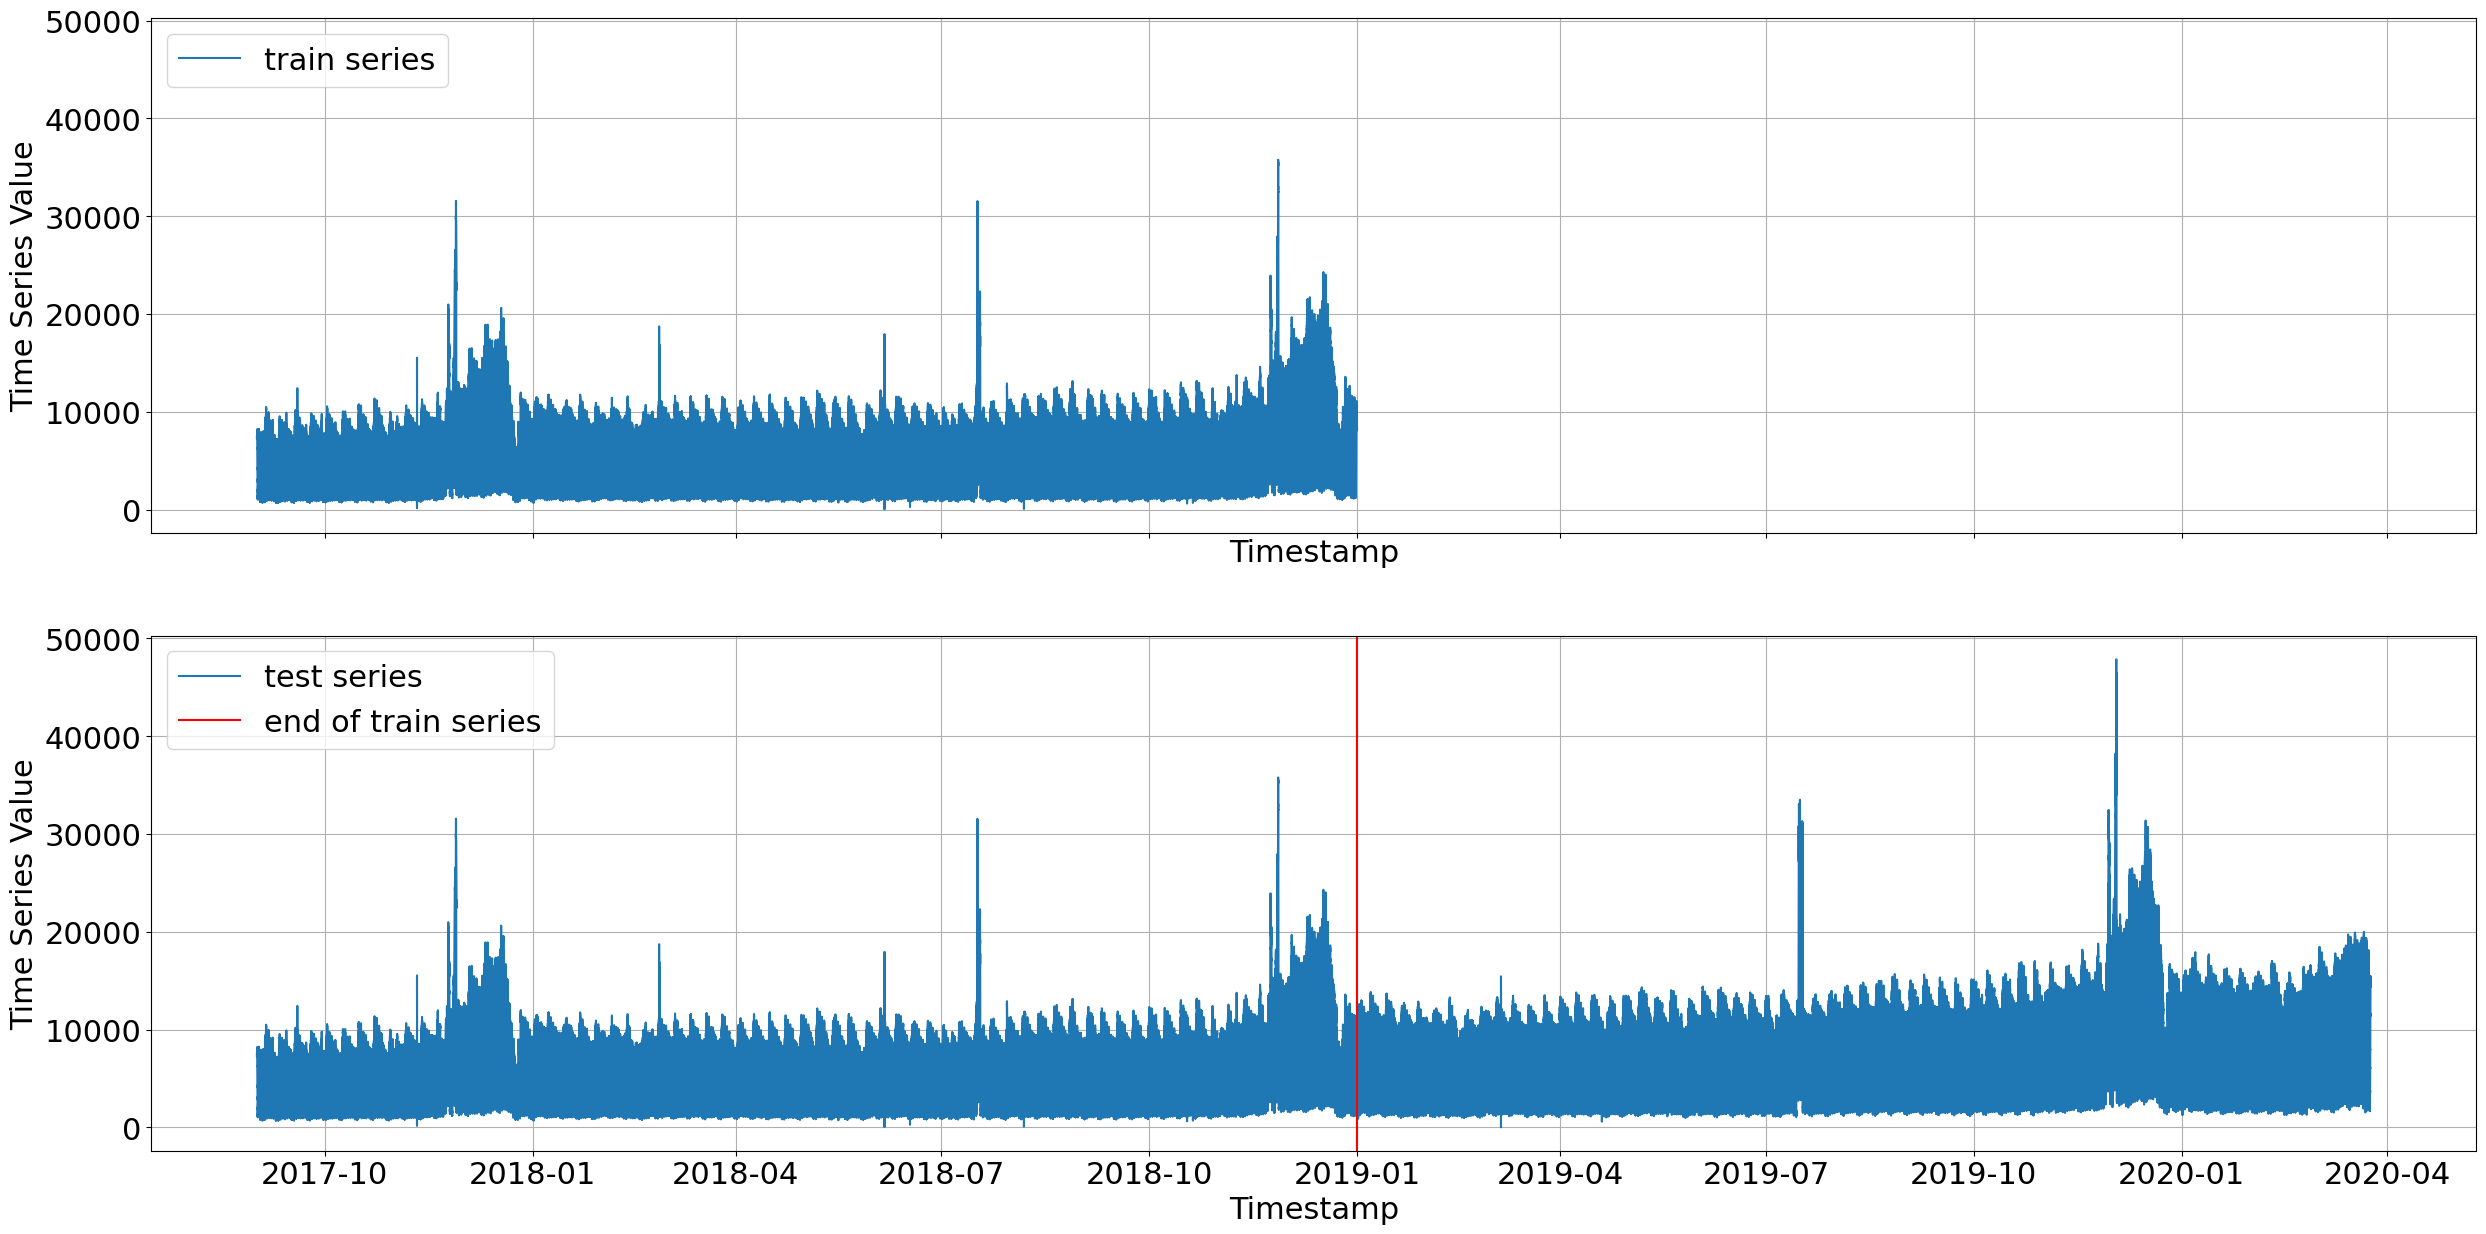

In [17]:
from mxnet import gluon
from gluonts.distribution import Gaussian, GaussianOutput


plt.rcParams["figure.figsize"] = (30, 15)
plt.rcParams["figure.dpi"] = 100
plt.rcParams['font.size'] = 22

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

ax[0].plot(d.timestamps[:701279], d.ts[:701279])
ax[0].legend(["train series"], loc="upper left")
ax[0].set_ylabel("Time Series Value")
ax[0].set_xlabel("Timestamp")
ax[0].grid(which="both")

ax[1].plot(d.timestamps, d.ts)
ax[1].axvline(d.timestamps[701279], color='r') # end of train dataset
ax[1].legend(["test series", "end of train series"], loc="upper left")
ax[1].set_ylabel("Time Series Value")
ax[1].set_xlabel("Timestamp")
ax[1].grid(which="both")


plt.show()

In [35]:
from gluonts.dataset.common import ListDataset

def mk_ds(df):
    havel_dict_data = df.to_havel_dict()
    feat_dynamic_cat = np.vstack([df.timestamps.hour.values, 
                                 df.timestamps.dayofweek.values, df.timestamps.month.values])
    
    target = havel_dict_data["target"]
    observed = [0 if np.isnan(x) else 1 for x in target]
    
    ds = ListDataset([{
        'feat_dynamic_cat': feat_dynamic_cat,
        'target': [0 if np.isnan(x) else x for x in target],
        'start': pd.to_datetime(havel_dict_data["start"]),
        'observed_values': observed,          
        }],
        freq='1min'
    )
    return ds

train_ds = mk_ds(d[:701279])

# havel_dict_data_test = d[701280:].to_havel_dict()
# feat_dynamic_cat_test = np.vstack([d.timestamps[701280:].hour.values, 
#                                    d.timestamps[701280:].dayofweek.values, d.timestamps[701280:].month.values])

# test_ds = ListDataset([{
#     "feat_dynamic_cat": feat_dynamic_cat_test,
#     "target": havel_dict_data_test["target"],
#     "start": pd.to_datetime(havel_dict_data_test["start"]),
# }], freq='1min')


# def mk_ds(df):
#     feat_dynamic_cat = np.vstack([df.timestamps.hour.values, df.timestamps.dayofweek.values, df.timestamps.month.values])
#     feat_dynamic_real = np.vstack([df['mean'].values]) # , df.stderr.values, df.dof.values 
    
#     target = df.peak_below.values
#     observed = [0 if np.isnan(x) else 1 for x in target]
    
#     ds = ListDataset([{
#         'feat_dynamic_cat': feat_dynamic_cat,
#         'feat_dynamic_real': feat_dynamic_real,
#         'target': [0 if np.isnan(x) else x for x in target],
#         'start': '2019-01-01 00:00:00',
#         'observed_values': observed
#                       }],
#         freq='1min'
#     )
#     return ds

# train_ds = mk_ds(d.tail(-1000).dropna()) # note the dropna!
# test_df = d.tail(10000).dropna() 
# test_ds = mk_ds(test_df) 

# test_df

# prediction_length=60, context_length=60*24

In [36]:
from gluonts.distribution import GaussianOutput

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=60,
    context_length=60*24,
    freq='1min',
    trainer = Trainer(
        epochs=50,
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-3,
        hybridize=False,
        ),
    distr_output = GaussianOutput()
)

predictor = estimator.train(train_ds)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 864622
100%|██████████| 100/100 [02:22<00:00,  1.42s/it, avg_epoch_loss=13.5]
INFO:root:Epoch[0] Elapsed time 142.314 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=13.506746
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [02:27<00:00,  1.48s/it, avg_epoch_loss=2.52e+3]
INFO:root:Epoch[1] Elapsed time 147.968 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=2523.213767
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [02:31<00:00,  1.51s/it, avg_epoch_loss=115]
INFO:root:Epoch[2] Elapsed time 151.156 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=115.217563
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [02:28<00:00,  1.49s/it, avg_epoch_loss=2.27e+6]
INFO:root:Epoch[3] Elapsed time 148.770 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=2267047.537548
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [02

100%|██████████| 100/100 [02:24<00:00,  1.44s/it, avg_epoch_loss=8.52]
INFO:root:Epoch[36] Elapsed time 144.074 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=8.520853
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [02:32<00:00,  1.52s/it, avg_epoch_loss=12.2]
INFO:root:Epoch[37] Elapsed time 152.037 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=12.221754
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [02:23<00:00,  1.44s/it, avg_epoch_loss=143]
INFO:root:Epoch[38] Elapsed time 143.897 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=142.591563
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [02:24<00:00,  1.44s/it, avg_epoch_loss=9.64]
INFO:root:Epoch[39] Elapsed time 144.362 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=9.637552
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [02:31<00:00,  1.51s/it, avg_epoch_loss=8.32]
INFO:root:Epoch[40] Elapsed time 15

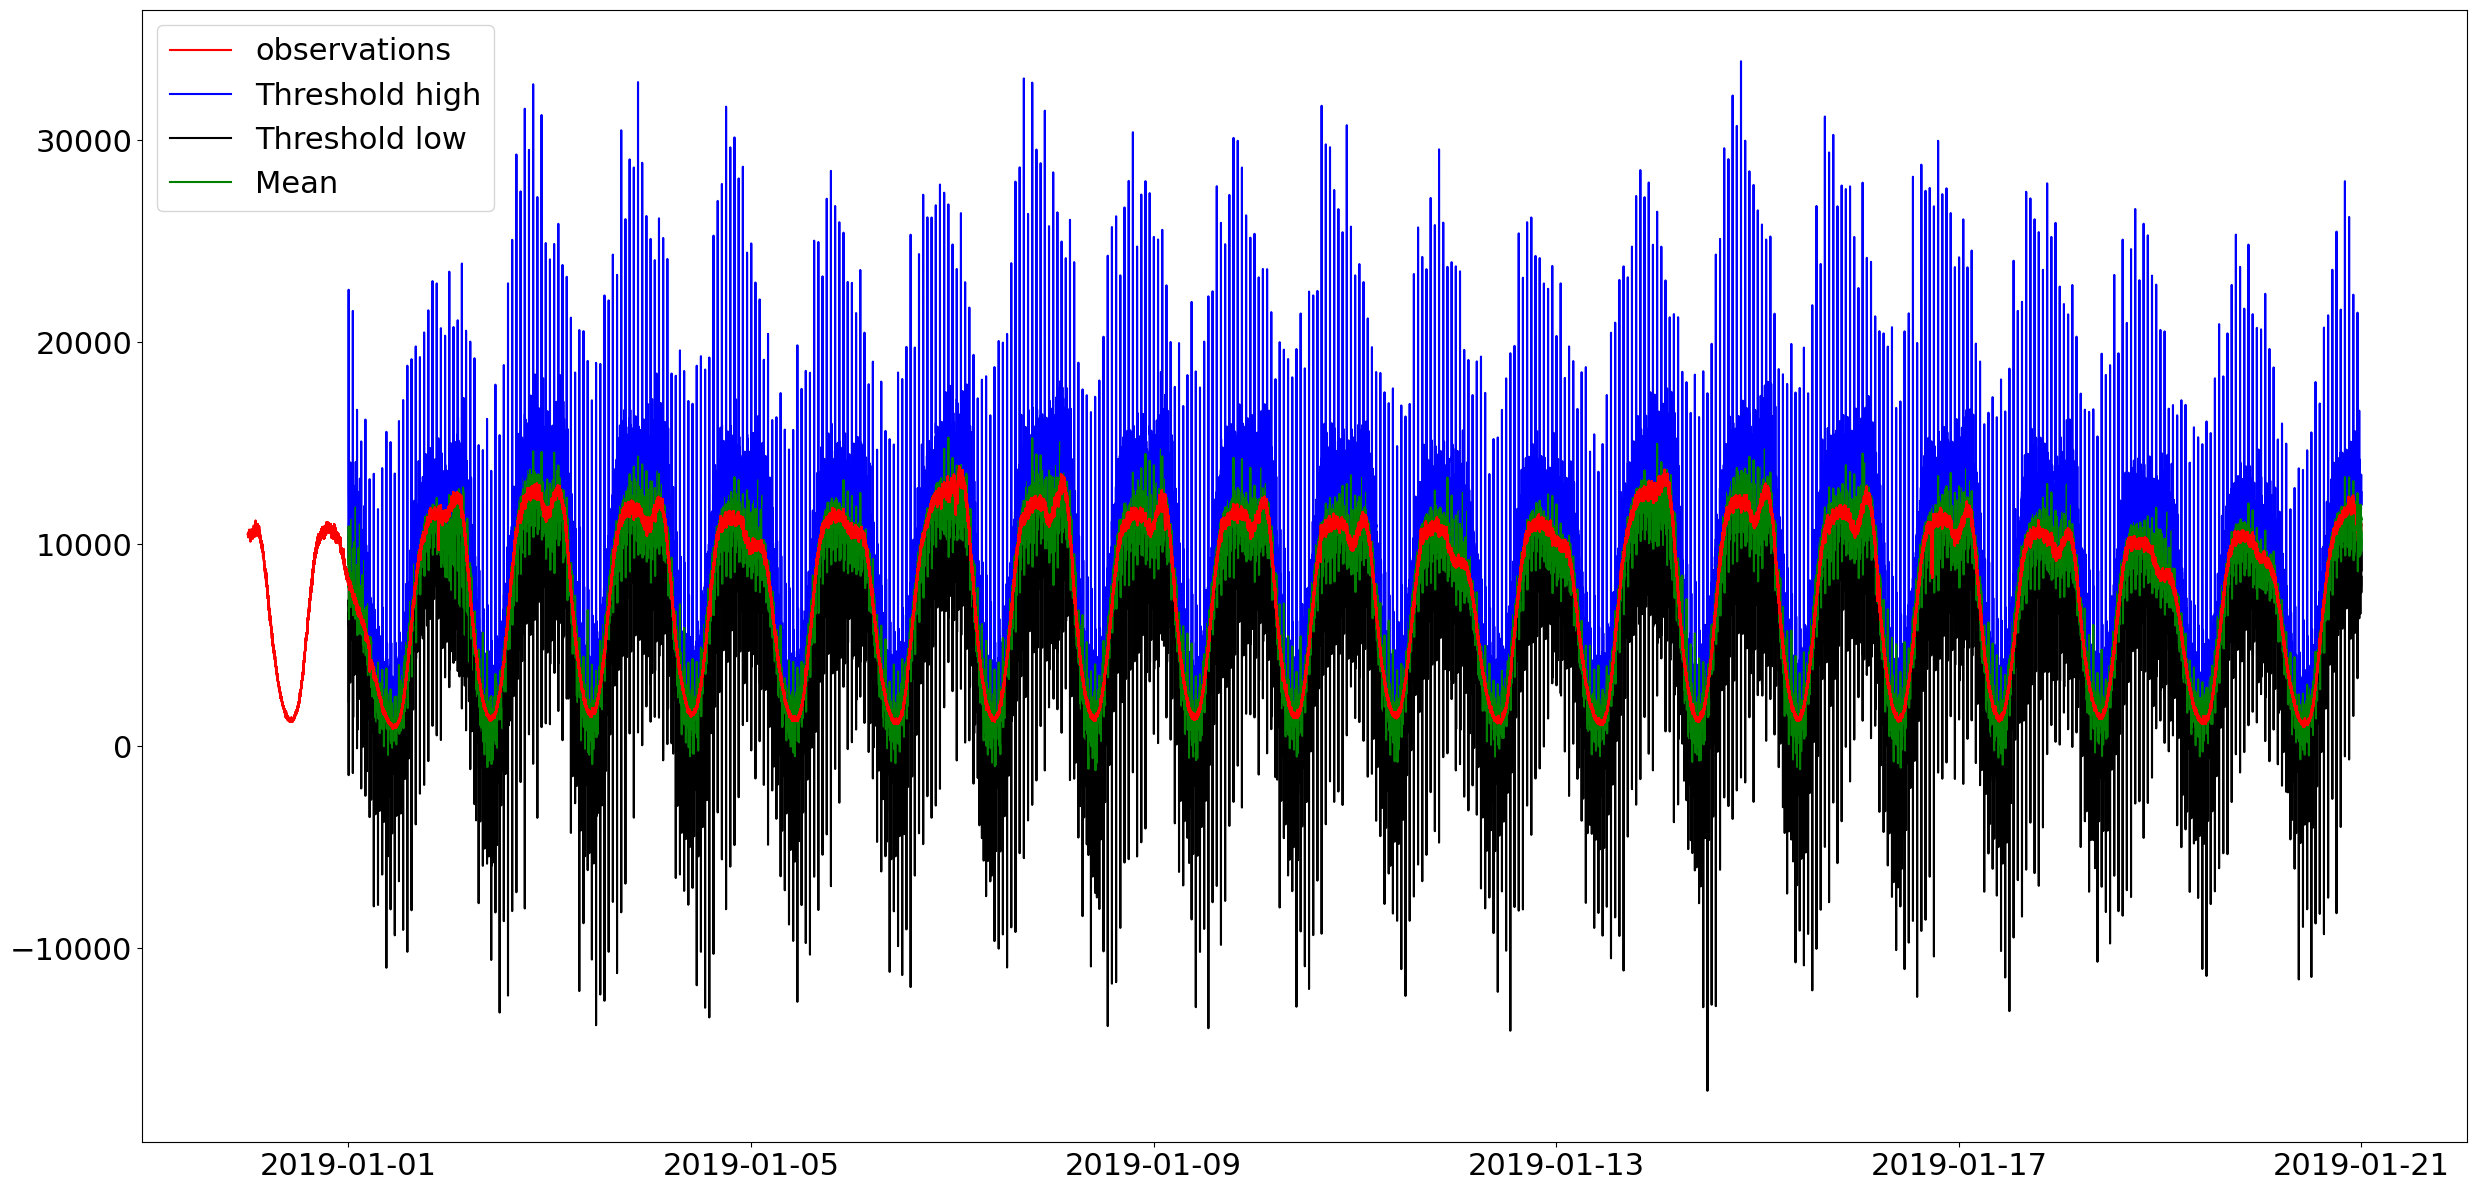

In [159]:
from gluonts.evaluation.backtest import make_evaluation_predictions

fig, ax = plt.subplots(1, 1)

def plot_prob_forecasts(recur, ts_entry, forecast_entry):
    plot_length = 60*25
#     prediction_intervals = (50.0,98.0)
#     legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    prediction_intervals = [98.0]
#     legend = ["observations", "median prediction"] + [f"{prediction_intervals[0]}% prediction interval"]
    legend = ["observations", "Threshold high", "Threshold low", "Mean"]
#     fig, ax = plt.subplots(1, 1)
#     ts_entry[-plot_length:].plot(ax=ax, color='r')  # plot the time series
    ax.plot(ts_entry, color='r', label='observations')
#     print(forecast_entry.quantile(0.98))
#     print(len(ts_entry))
#     forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.plot(d.timestamps[701280-60*24*1+60*recur+60*24*1:701280-60*24*1+60*recur+60*24*1+60], forecast_entry.quantile(0.98), color='b', label='Threshold high')
    ax.plot(d.timestamps[701280-60*24*1+60*recur+60*24*1:701280-60*24*1+60*recur+60*24*1+60], forecast_entry.quantile(0.02), color='black', label='Threshold low')
    ax.plot(d.timestamps[701280-60*24*1+60*recur+60*24*1:701280-60*24*1+60*recur+60*24*1+60], forecast_entry.mean, color='g', label='Mean')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
#     plt.show()
    
peakover = []
peakover_point = []
peakbelow = []
peakbelow_point = []
threshold_over = []
threshold_below = []
mean = []

period = 480

for recur in range(period):
    #test_ds = mk_ds(d[701280+60*4+recur*60*24:701280+60*4+60*24*9+60-1+recur*60*24]) #End: 1347422
    #test_ds = mk_ds(d[701280:])
    test_ds = mk_ds(d[701280-60*24*1+60*recur:701280-60*24*1+60*recur+60*24*1+60]) #End: 1347422
    #test_ds = mk_ds(d[0:701280-60*24*1+60*recur+60*24*1+60]) #End: 1347422

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)

    # first entry of the time series list
    ts_entry = tss[0]

    # first entry of test_ds
    test_ds_entry = next(iter(test_ds))

    # first entry of the forecast list
    forecast_entry = forecasts[0]
    
    #Compute the threshold above and below the series, and compute the extreme values
    threshold_over.extend(forecast_entry.quantile(0.98))
    threshold_below.extend(forecast_entry.quantile(0.02))
    mean.extend(forecast_entry.mean)
#     print(len(ts_entry[0]))
#     print(ts_entry)
    for i in range(len(forecast_entry.quantile(0.98))):
        threshold_high = (forecast_entry.quantile(0.98))[i]
        threshold_low = (forecast_entry.quantile(0.02))[i]
        peakover.append(ts_entry[0][1440+i] - threshold_high if ts_entry[0][1440+i] - threshold_high >= 0 else np.nan)
        peakover_point.append(ts_entry[0][1440+i] if ts_entry[0][1440+i] - threshold_high >= 0 else np.nan)
        peakbelow.append(threshold_low - ts_entry[0][1440+i] if ts_entry[0][1440+i] - threshold_low <= 0 else np.nan)
        peakbelow_point.append(ts_entry[0][1440+i] if ts_entry[0][1440+i] - threshold_low <= 0 else np.nan)

    plot_prob_forecasts(recur, ts_entry, forecast_entry)

plt.show()

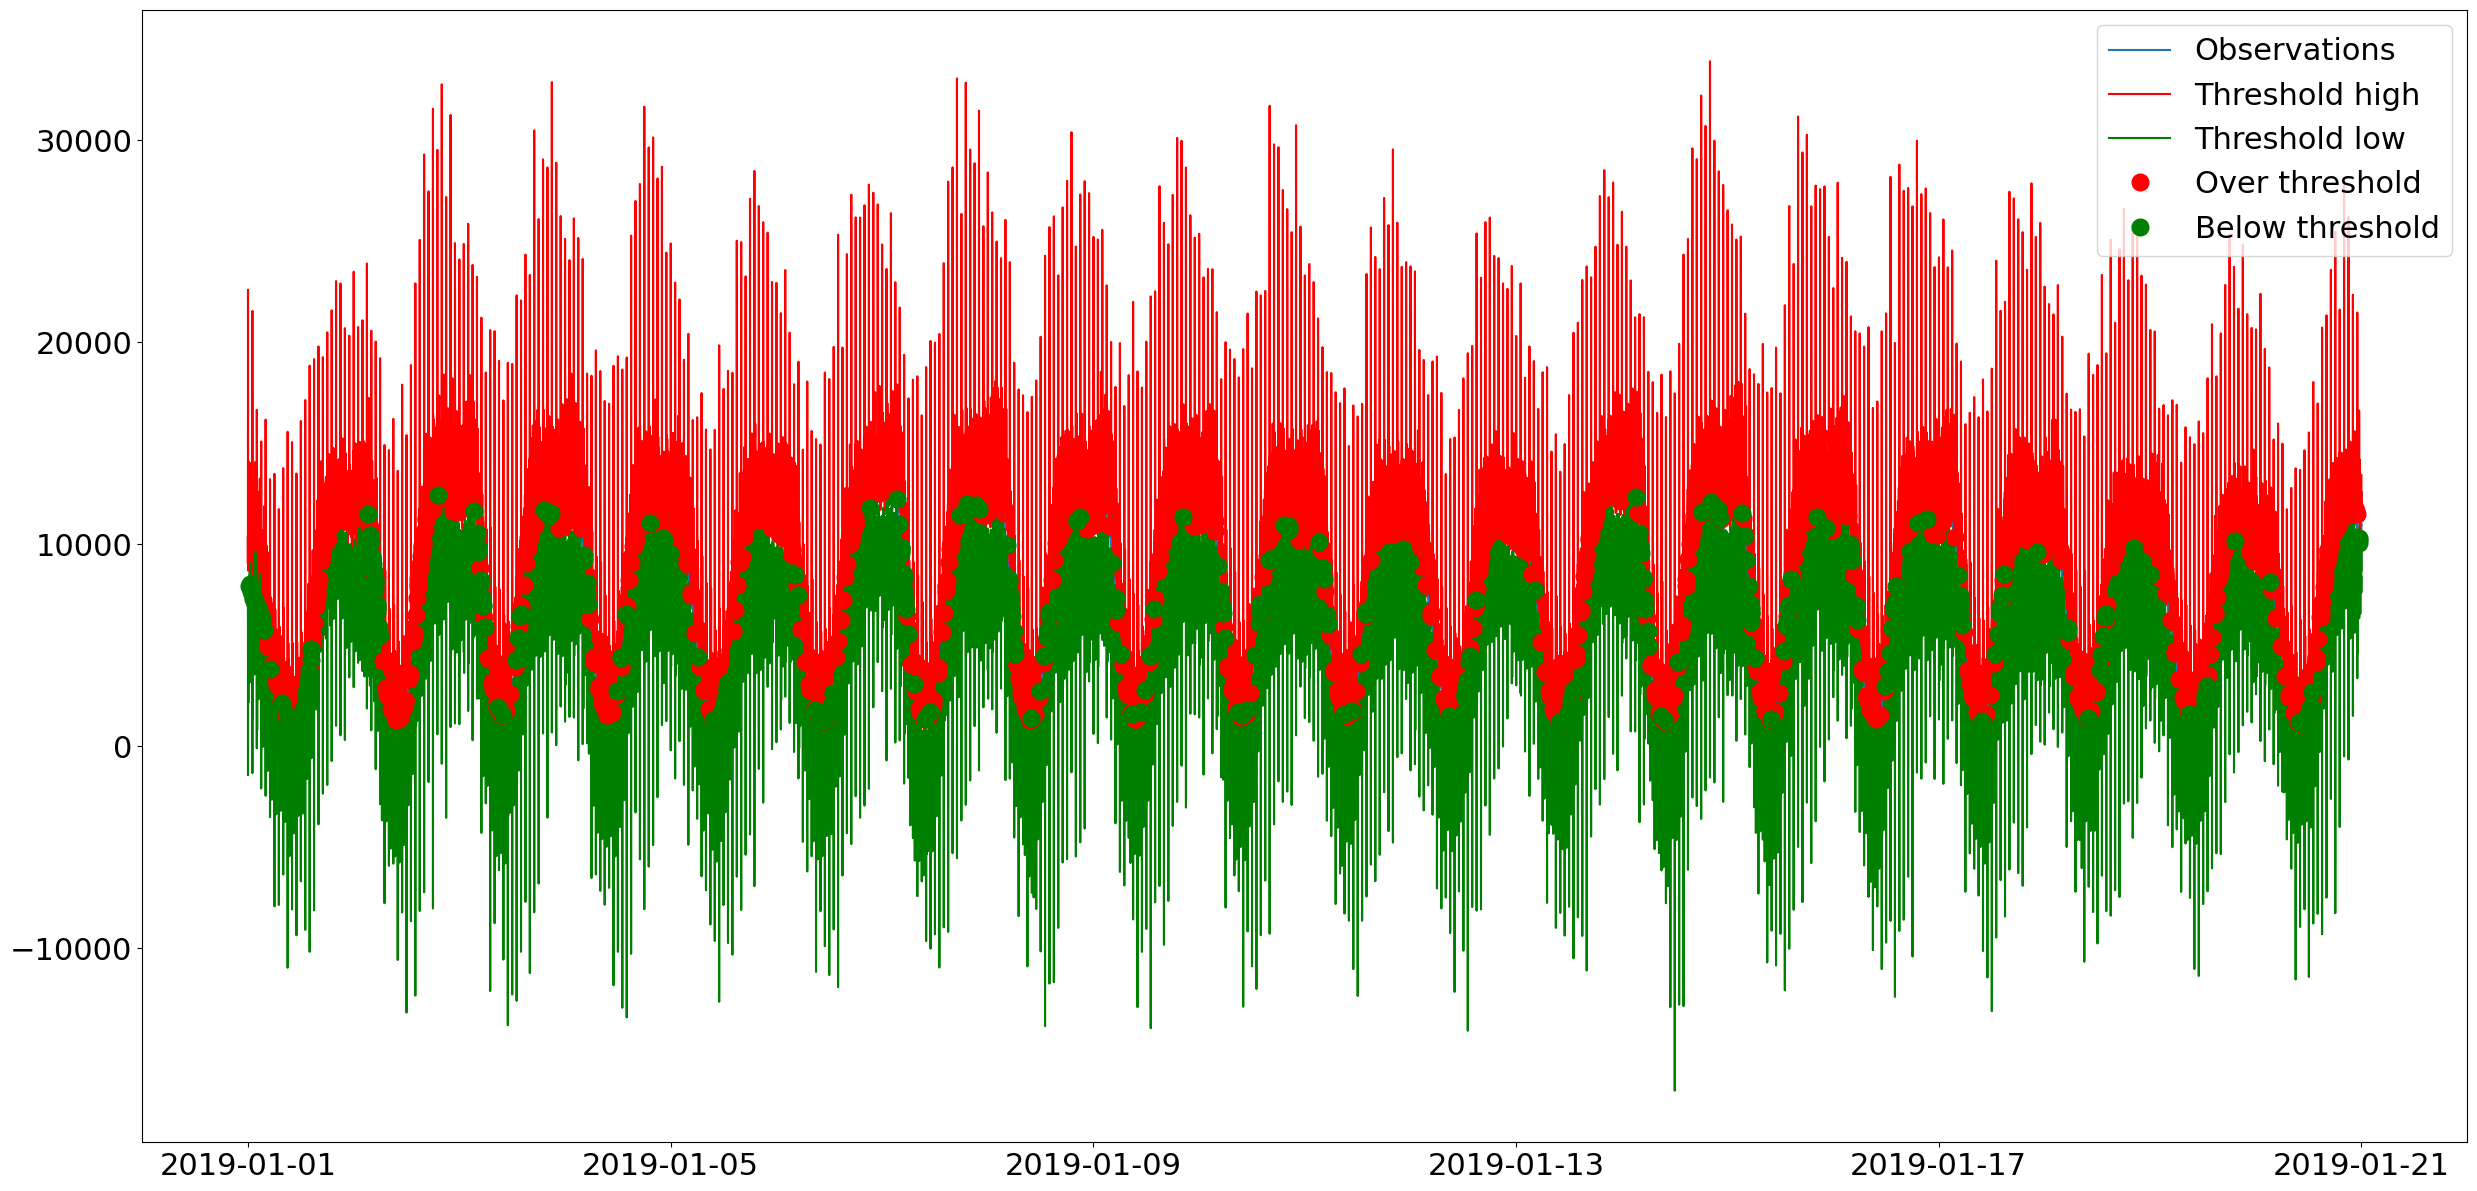

In [160]:
def plot_peaks():
    fig, ax = plt.subplots()
    #fig.set_size_inches(18.5, 10.5)
    
    ax.plot(d.timestamps[701280:701280+60*period], d.ts[701280:701280+60*period], label='Observations')
    ax.plot(d.timestamps[701280:701280+60*period], threshold_over, color='r', label='Threshold high')
    ax.plot(d.timestamps[701280:701280+60*period], threshold_below, color='g', label='Threshold low')
    
    ax.plot(d.timestamps[701280:701280+60*period], peakover_point, marker='o', color='r', linestyle = 'None', label='Over threshold', markersize = 12)
    ax.plot(d.timestamps[701280:701280+60*period], peakbelow_point, marker='o', color='g', linestyle = 'None', label='Below threshold', markersize = 12)
    
    ax.legend()
    
plot_peaks()

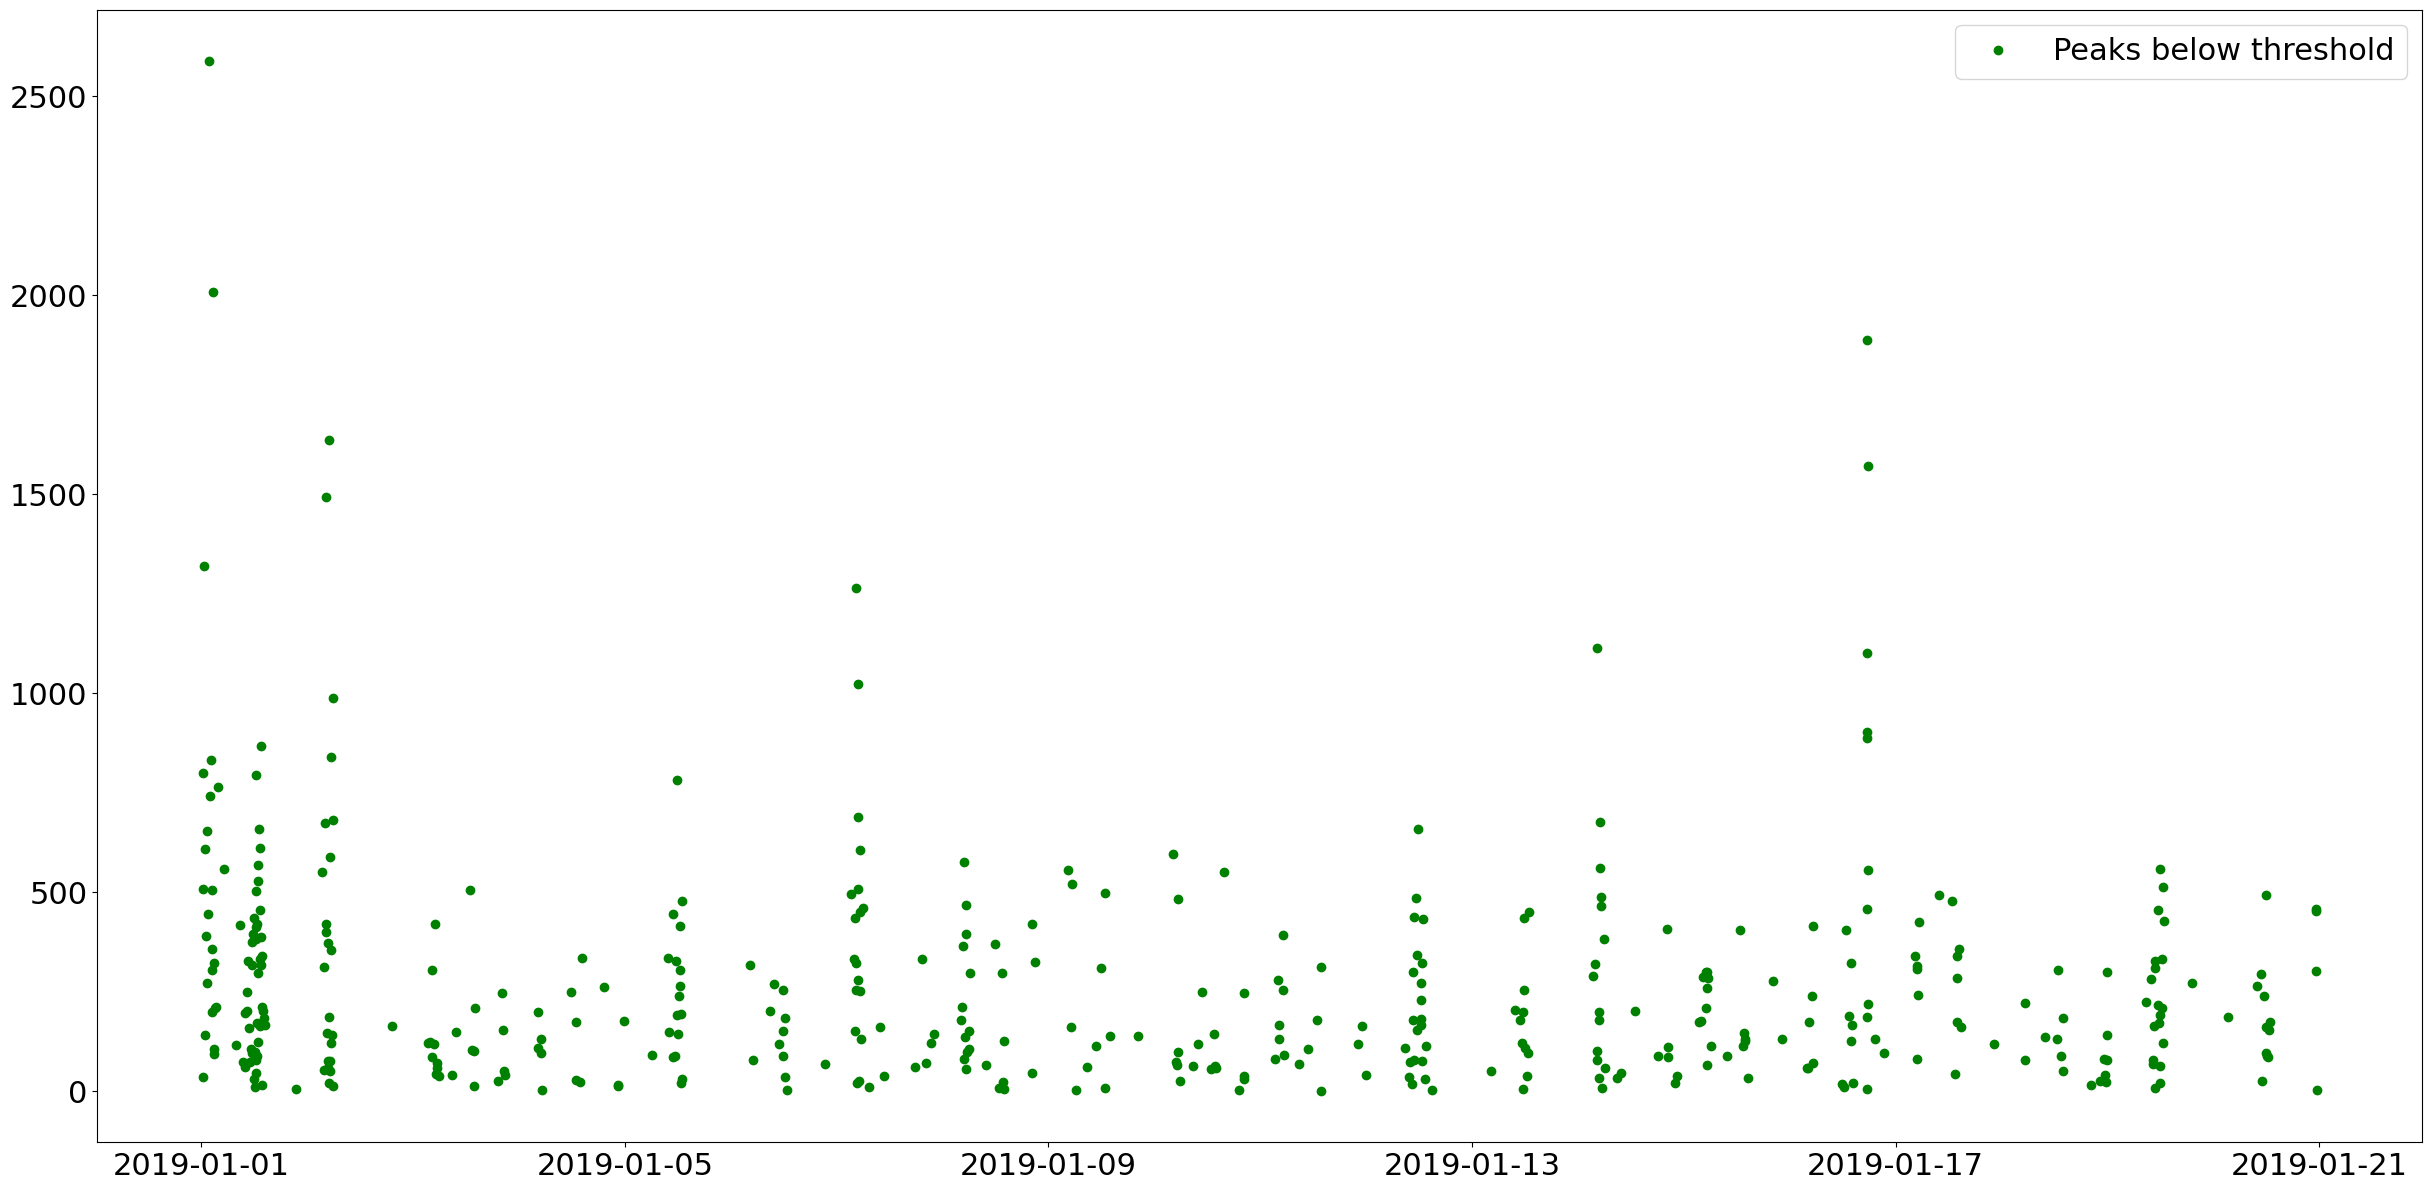

In [161]:
def plot_peakbelow():
    fig, ax = plt.subplots()
    #fig.set_size_inches(18.5, 10.5)

    ax.plot(d.timestamps[701280:701280+60*period], peakbelow, marker='o', color='g', linestyle = 'None', label='Peaks below threshold')
    #ax.plot(df['peak_over'], marker='o', color='r', linestyle = 'None', label='Peaks over threshold')
    ax.legend()

plot_peakbelow()

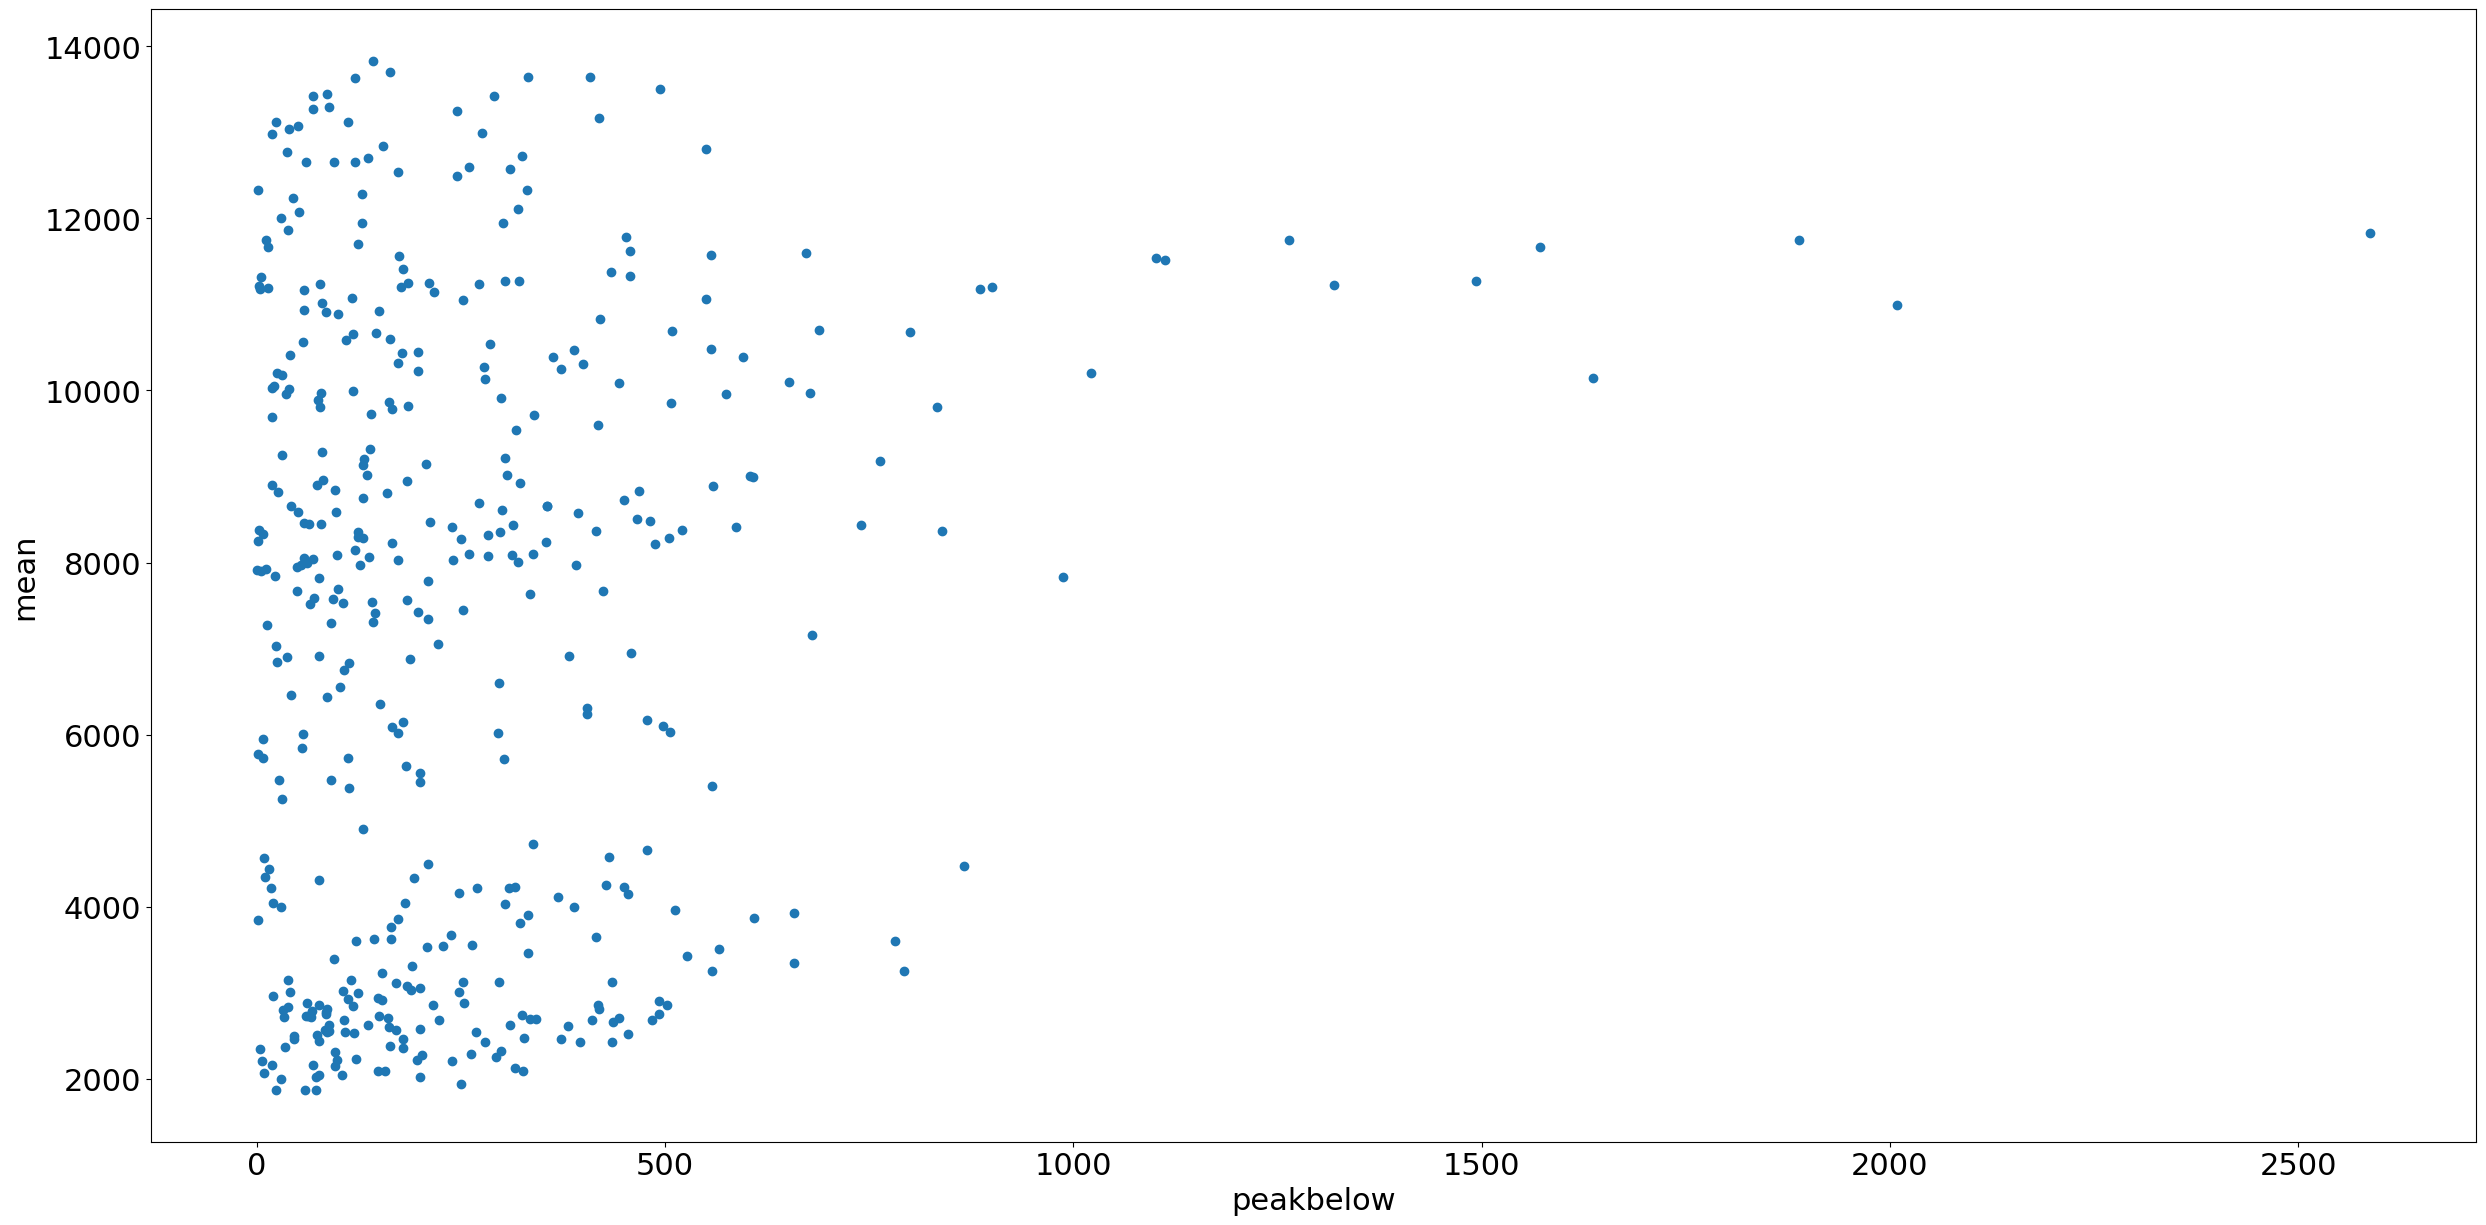

In [167]:
def plot_peakbelow_mean():
    plt.xlabel('peakbelow')
    plt.ylabel('mean')
    plt.scatter(peakbelow, mean)

plot_peakbelow_mean()

In [180]:
dataSeries = pd.DataFrame({'observations': d.ts[701280:701280+60*period], 
                           'forecast_date': d.timestamps[701280:701280+60*period],
                           'mean': mean,
                           'peakbelow': peakbelow,
                           'peakover': peakover,
                           'threshold_over': threshold_over,
                           'threshold_below': threshold_below,
                           'mean': mean,})
dataSeries['forecast_date'] = pd.to_datetime(dataSeries['forecast_date'])
dataSeries = dataSeries.set_index('forecast_date', drop=True)
dataSeries['hour'] = dataSeries.index.hour
dataSeries['dayofweek'] = dataSeries.index.dayofweek
dataSeries['weekofyear'] = dataSeries.index.weekofyear
dataSeries['month'] = dataSeries.index.month

dataSeries

,observations,mean,peakbelow,hour,dayofweek,weekofyear,month
forecast_date,,,,,,,
2019-01-01 00:00:00,8131.0,8693.213867,NaN,0,1,1,1
2019-01-01 00:01:00,8305.0,7954.560547,NaN,0,1,1,1
2019-01-01 00:02:00,8157.0,7856.886230,NaN,0,1,1,1
2019-01-01 00:03:00,7982.0,10889.257812,NaN,0,1,1,1
2019-01-01 00:04:00,8228.0,9840.898438,NaN,0,1,1,1
...,...,...,...,...,...,...,...
2019-01-20 23:55:00,10886.0,11390.786133,NaN,23,6,3,1
2019-01-20 23:56:00,10970.0,11207.174805,NaN,23,6,3,1
2019-01-20 23:57:00,11038.0,11301.839844,NaN,23,6,3,1


In [184]:
def mk_ds_extreme(df):
    feat_dynamic_cat = np.vstack([df.hour.values, df.dayofweek.values, df.month.values])
    feat_dynamic_real = np.vstack([df['mean'].values]) # , df.stderr.values, df.dof.values 
    
    target = df.peakbelow.values
    observed = [0 if np.isnan(x) else 1 for x in target]
    
    ds = ListDataset([{
        'feat_dynamic_cat': feat_dynamic_cat,
        'feat_dynamic_real': feat_dynamic_real,
        'target': [0 if np.isnan(x) else x for x in target],
        'start': '2019-01-01 00:00:00',
        'observed_values': observed
                      }],
        freq='1min'
    )
    return ds

train_ds_extreme = mk_ds_extreme(dataSeries.tail(-1000).dropna())
test_df_extreme = dataSeries.tail(10000).dropna()
test_ds_extreme = mk_ds_extreme(test_df_extreme)

dataSeries.tail(-1000).dropna()

,observations,mean,peakbelow,hour,dayofweek,weekofyear,month
forecast_date,,,,,,,
2019-01-01 21:33:00,9726.0,11183.271484,3.320312,21,1,1,1
2019-01-02 03:20:00,11483.0,12811.369141,549.568359,3,2,1,1
2019-01-02 03:49:00,10388.0,12569.271484,310.101562,3,2,1,1
2019-01-02 03:50:00,10446.0,12079.298828,51.457031,3,2,1,1
2019-01-02 03:57:00,10095.0,11594.299805,672.269531,3,2,1,1
...,...,...,...,...,...,...,...
2019-01-20 12:51:00,2687.0,3855.629883,173.503174,12,6,3,1
2019-01-20 23:17:00,10244.0,11624.700195,457.252930,23,6,3,1
2019-01-20 23:20:00,10297.0,11786.025391,451.790039,23,6,3,1


# SimpleFeedForward Model on the Extreme Values

In [ ]:
class PeakOverThresholdGeneralizedPareto(Distribution):
    r"""
    The Generalized Pareto is a continuous distribution defined on the real line.
    This distribution is often used to model the tails of other distributions.


    Parameters
    ----------
      scale: The scale of the distribution. GeneralizedPareto is a
        location-scale distribution, so doubling the `scale` doubles a sample
        and halves the density. Strictly positive floating point `Tensor`. Must
        broadcast with `concentration`.
        
      concentration: The shape parameter of the distribution,
      mapped to `concentration > 0` for heavy tails.
    F
    """
    
    is_reparameterizable = False

    @validated()
    def __init__(self, scale: Tensor, concentration: Tensor, F=None) -> None:
        self.scale = scale
        self.concentration = concentration
        self.F = F if F else getF(concentration)

    @property
    def batch_shape(self) -> Tuple:
        return self.concentration.shape

    @property
    def event_shape(self) -> Tuple:
        return ()

    @property
    def event_dim(self) -> int:
        return 0

    def log_prob(self, x: Tensor) -> Tensor:
        F = self.F
        z = x / self.scale        

        ll = (- F.log(self.scale) 
              - ((self.concentration + 1) / self.concentration) 
              * F.log1p(self.concentration * z))
        
        return ll

    @property
    def mean(self) -> Tensor:
        # Mean is only defined for concentration < 1. How to handle that?
        mu = self.scale / (1 - self.concentration)
        return mu
    

    @property
    def stddev(self) -> Tensor:
        # Variance is only defined for concentration < 1/2. How?
        F = self.F
        return self.scale / ((1 - self.concentration)* self.F.sqrt(1 - 2 * self.concentration))
        
        
    def cdf(self, x: Tensor) -> Tensor:
        F = self.F
        z = x / self.scale
        u = 1 - F.power(1 + self.concentration * z, - 1 / self.concentration )
        return u
        
    
    def base_distribution_quantile(self, level: Tensor, threshold: Tensor, peak_ratio: Tensor, transforms, below=False) -> Tensor:
        """
        Computes the tail quantile of the base distribution using the fitted extreme value distribution. 
        """
        
        F = self.F
        sgn = -1 if below else 1
        
        # Base GPD quantile
        base_q = (self.scale/self.concentration) * (F.power( level / peak_ratio, -self.concentration) - 1)
        
        # Reversing the transforms
        for t in transforms:
            base_q = t.f(base_q)
        
        # Applying over/below threshold
        q = threshold + sgn * base_q
        
        return q
        

    def sample(
        self, num_samples: Optional[int] = None, dtype=np.float32
    ) -> Tensor:
        def s(scale: Tensor, concentration: Tensor) -> Tensor:
            F = self.F
            ones = concentration.ones_like()

            smpl = scale * (F.power(
                F.random.uniform(0 * ones, 1 * ones, dtype=dtype),
                -concentration) - 1) / concentration
        
            return smpl
            
        return _sample_multiple(s, scale=self.scale, concentration=self.concentration, num_samples=num_samples)

    @property
    def args(self) -> List:
        return [self.scale, self.concentration]

    
class PeakOverThresholdGeneralizedParetoOutput(DistributionOutput):
    args_dim: Dict[str, int] = {"scale": 1, "concentration": 1}
    distr_cls: type = PeakOverThresholdGeneralizedPareto

    @classmethod
    def domain_map(cls, F, scale, concentration):
        scale = 1e-4 + softplus(F, scale)  
        concentration = 1e-4 + softplus(F, concentration)
        return scale.squeeze(axis=-1), concentration.squeeze(axis=-1)

    @property
    def event_shape(self) -> Tuple:
        return ()

In [ ]:
from typing import List, Tuple

# Third-party imports
import mxnet as mx

# First-party imports
from gluonts.block.scaler import MeanScaler, NOPScaler
from gluonts.core.component import validated
from gluonts.distribution import Distribution, DistributionOutput
from gluonts.model.common import Tensor


class FeedForwardNetworkBase(mx.gluon.HybridBlock):
    """
    Abstract base class to implement feed-forward networks for probabilistic
    time series prediction.

    This class does not implement hybrid_forward: this is delegated
    to the two subclasses SimpleFeedForwardTrainingNetwork and
    SimpleFeedForwardPredictionNetwork, that define respectively how to
    compute the loss and how to generate predictions.

    Parameters
    ----------
    num_hidden_dimensions
        Number of hidden nodes in each layer.
    prediction_length
        Number of time units to predict.
    context_length
        Number of time units that condition the predictions.
    batch_normalization
        Whether to use batch normalization.
    mean_scaling
        Scale the network input by the data mean and the network output by
        its inverse.
    distr_output
        Distribution to fit.
    kwargs
    """

    # Needs the validated decorator so that arguments types are checked and
    # the block can be serialized.
    @validated()
    def __init__(
        self,
        num_hidden_dimensions: List[int],
        prediction_length: int,
        context_length: int,
        batch_normalization: bool,
        mean_scaling: bool,
        distr_output: DistributionOutput,
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)

        self.num_hidden_dimensions = num_hidden_dimensions
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.batch_normalization = batch_normalization
        self.mean_scaling = mean_scaling
        self.distr_output = distr_output

        with self.name_scope():
            self.distr_args_proj = self.distr_output.get_args_proj()
            self.mlp = mx.gluon.nn.HybridSequential()
            dims = self.num_hidden_dimensions
            for layer_no, units in enumerate(dims[:-1]):
                self.mlp.add(mx.gluon.nn.Dense(units=units, activation="relu"))
                if self.batch_normalization:
                    self.mlp.add(mx.gluon.nn.BatchNorm())
            self.mlp.add(mx.gluon.nn.Dense(units=prediction_length * dims[-1]))
            self.mlp.add(
                mx.gluon.nn.HybridLambda(
                    lambda F, o: F.reshape(
                        o, (-1, prediction_length, dims[-1])
                    )
                )
            )
            self.scaler = MeanScaler() if mean_scaling else NOPScaler()

    def get_distr_args_loc_scale(
        self, F, past_target: Tensor
    ) -> Tuple[Tuple[Tensor, ...], Tensor, Tensor]:
        """
        Given past target values, applies the feed-forward network and
        maps the output to a probability distribution for future observations.

        Parameters
        ----------
        F
        past_target
            Tensor containing past target observations.
            Shape: (batch_size, context_length, target_dim).

        Returns
        -------
        Distribution
            The predicted probability distribution for future observations.
        """

        # (batch_size, seq_len, target_dim) and (batch_size, seq_len, target_dim)
        scaled_target, target_scale = self.scaler(
            past_target,
            F.ones_like(past_target),  # TODO: pass the actual observed here
        )
        mlp_outputs = self.mlp(scaled_target)
        distr_args = self.distr_args_proj(mlp_outputs)

        return distr_args, F.zeros_like(target_scale), target_scale


class FeedForwardTrainingNetwork(FeedForwardNetworkBase):#inside train_model()
    # noinspection PyMethodOverriding,PyPep8Naming
    def hybrid_forward(
        self, F, past_target: Tensor, future_target: Tensor
    ) -> Tensor:
        distr_args, loc, scale = self.get_distr_args_loc_scale(F, past_target)

        distr = self.distr_output.distribution(
            distr_args, scale=scale.expand_dims(axis=1)
        )

        # (batch_size, prediction_length, target_dim)
        loss = distr.loss(future_target)

        # (batch_size, )
        return loss.mean(axis=1)


class FeedForwardPredictionNetwork(FeedForwardNetworkBase):#inside train_model() self.create_predictor()
    # noinspection PyMethodOverriding,PyPep8Naming
    def hybrid_forward(
        self, F, past_target: Tensor
    ) -> Tuple[Tuple[Tensor, ...], Tensor, Tensor]:
        distr_args, loc, scale = self.get_distr_args_loc_scale(F, past_target)
        return distr_args, scale



In [ ]:
from typing import List, Optional

# Third-party imports
from mxnet.gluon import HybridBlock

# First-party imports
from gluonts.core.component import validated
from gluonts.dataset.field_names import FieldName
from gluonts.distribution import DistributionOutput, GaussianOutput
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.model.forecast_generator import DistributionForecastGenerator
from gluonts.trainer import Trainer
from gluonts.transform import (
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    Transformation,
    AsNumpyArray,
)
from gluonts.support.util import copy_parameters


class FeedForwardEstimator(GluonEstimator):#Return gluonts.model.estimator.GluonEstimator train_model 


    """
    FeedForwardEstimator

    Parameters
    ----------
    freq
        Time time granularity of the data
    prediction_length
        Length of the prediction horizon
    trainer
        Trainer object to be used (default: Trainer())
    num_hidden_dimensions
        Number of hidden nodes in each layer (default: [40, 40])
    context_length
        Number of time units that condition the predictions
        (default: None, in which case context_length = prediction_length)
    distr_output
        Distribution to fit (default: GaussianOutput())
    batch_normalization
        Whether to use batch normalization (default: False)
    mean_scaling
        Scale the network input by the data mean and the network output by
        its inverse (default: True)
    num_parallel_samples
        Number of evaluation samples per time series to increase parallelism during inference.
        This is a model optimization that does not affect the accuracy (default: 100)
    """

    # The validated() decorator makes sure that parameters are checked by
    # Pydantic and allows to serialize/print models. Note that all parameters
    # have defaults except for `freq` and `prediction_length`. which is
    # recommended in GluonTS to allow to compare models easily.
    @validated()
    def __init__(
        self,
        freq: str,
        prediction_length: int,
        trainer: Trainer = Trainer(),
        num_hidden_dimensions: Optional[List[int]] = None,
        context_length: Optional[int] = None,
        distr_output: DistributionOutput = GaussianOutput(),
        batch_normalization: bool = False,
        mean_scaling: bool = True,
        num_parallel_samples: int = 100,
    ) -> None:
        """
        Defines an estimator. All parameters should be serializable.
        """
        super().__init__(trainer=trainer)

        assert (
            prediction_length > 0
        ), "The value of `prediction_length` should be > 0"
        assert (
            context_length is None or context_length > 0
        ), "The value of `context_length` should be > 0"
        assert num_hidden_dimensions is None or (
            [d > 0 for d in num_hidden_dimensions]
        ), "Elements of `num_hidden_dimensions` should be > 0"
        assert (
            num_parallel_samples > 0
        ), "The value of `num_parallel_samples` should be > 0"

        self.num_hidden_dimensions = (
            num_hidden_dimensions
            if num_hidden_dimensions is not None
            else list([40, 40])
        )
        self.prediction_length = prediction_length
        self.context_length = (
            context_length if context_length is not None else prediction_length
        )
        self.freq = freq
        self.distr_output = distr_output
        self.batch_normalization = batch_normalization
        self.mean_scaling = mean_scaling
        self.num_parallel_samples = num_parallel_samples

    # here we do only a simple operation to convert the input data to a form
    # that can be digested by our model by only splitting the target in two, a
    # conditioning part and a to-predict part, for each training example.
    # fFr a more complex transformation example, see the `gluonts.model.deepar`
    # transformation that includes time features, age feature, observed values
    # indicator, ...
    def create_transformation(self) -> Transformation:
        return Chain(
            [
                AsNumpyArray(field=FieldName.TARGET, expected_ndim=1),
                InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                    time_series_fields=[FieldName.FEAT_DYNAMIC_REAL, FieldName.FEAT_DYNAMIC_CAT]
                )
            ]
        )

    # defines the network, we get to see one batch to initialize it.
    # the network should return at least one tensor that is used as a loss to minimize in the training loop.
    # several tensors can be returned for instance for analysis, see DeepARTrainingNetwork for an example.
    def create_training_network(self) -> HybridBlock:
        return FeedForwardTrainingNetwork(
            num_hidden_dimensions=self.num_hidden_dimensions,
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            batch_normalization=self.batch_normalization,
            mean_scaling=self.mean_scaling,
        )

    # we now define how the prediction happens given that we are provided a
    # training network.
    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = FeedForwardPredictionNetwork(
            num_hidden_dimensions=self.num_hidden_dimensions,
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            batch_normalization=self.batch_normalization,
            mean_scaling=self.mean_scaling,
        )

        copy_parameters(net_source=trained_network, net_dest=prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            forecast_generator=DistributionForecastGenerator(
                self.distr_output
            ),
            ctx=self.trainer.ctx,
        )



In [ ]:
trainer_extreme = Trainer(
        epochs=50,
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-3,
        hybridize=False,
        )

In [ ]:
prediction_length=20

model_extreme = FeedForwardEstimator(
    freq='1min',
    prediction_length=prediction_length,
    num_hidden_dimensions=4*[20],
    context_length=180,
    trainer=trainer_extreme,
    mean_scaling=True,
    distr_output = PeakOverThresholdGeneralizedParetoOutput()
)

forecaster_extreme = model_extreme.train_model(train_ds_extreme)
predictor_extreme = forecaster_extreme.predictor

In [ ]:
def plot_prob_forecasts(target, threshold, samples, test_df, prediction_length, alarm_level, peak_ratio, transforms):
    percentiles = [50, 75, 90, 95, 99]
    legend = ["observations", "threshold", "cutoff"] + [f"p{k} of the Generalized Pareto" for k in percentiles]

    idx = test_df.tail(prediction_length).index
    
    fig, ax = plt.subplots(prediction_length, 1, figsize=(10, 10 * prediction_length))
    
    # Compute the absolute target
    adjusted_target = threshold - target
    
    # Compute percentiles of the predictive distribution
    pct = np.percentile(samples, percentiles, axis=0)

    # Compute alarm cutoff 
    cutoff = p.distribution.base_distribution.base_distribution_quantile(
        level=alarm_level,
        threshold=mx.nd.array(threshold),
        peak_ratio=peak_ratio,
        transforms=transforms,
        below=True
    ).asnumpy()
    
    for sp in range(prediction_length):
        ax[sp].set_title(f"Date: {idx[sp]}\n Peak below: {target[sp]} \n Alarm quantile: {alarm_level}")

        # plot the time series
        pd.Series(adjusted_target[sp]).plot(ax=ax[sp], linestyle = 'None', marker = 'o', markersize=20 )  
        
        # plot the time series
        pd.Series(threshold[sp]).plot(ax=ax[sp], linestyle = 'None', marker = 'o', markersize=20, color='g')

        # plot the cut-off
        pd.Series(cutoff[sp]).plot(ax=ax[sp], linestyle = 'None', marker = '^', markersize=20, color='r')
        
        # plot the percentiles of the GPD
        for i in range(len(percentiles)):
            adjusted_percentile = threshold - pct[i,:]
            pd.Series(data=adjusted_percentile[sp]).plot(
                    ax=ax[sp], marker='X', markersize=10, color=cm.hot(i/len(percentiles)), linestyle = 'None')


        ax[sp].grid(which="both")

    fig.legend(legend, loc="best")
    plt.show()

In [ ]:
pred_extreme = predictor_extreme.predict(test_ds_extreme)
p_extreme = next(iter(pred_extreme))
p_extreme.distribution

In [ ]:
tss_extreme = list(test_ds_extreme)
target_extreme = tss_extreme[0]['target'][-prediction_length:]#mk_ds
threshold_extreme = test_df_extreme.threshold_below.tail(prediction_length).values
peak_ratio_extreme = peak_df_extreme.peakbelow.notna().sum() / peak_df_extreme.peak_below.size
peak_ratio_extreme

In [ ]:
samples_extreme = p_extreme.distribution.sample(1000).asnumpy()
alarm_level = 1e-4

plot_prob_forecasts(target_extreme,
                    threshold_extreme,
                    samples_extreme,
                    test_df_extreme,
                    prediction_length,
                    alarm_level,
                    peak_ratio_extreme,
                    p_extreme.distribution.transforms)

In [ ]:
dataSeries.score[dataSeries.score<0.3].hist(bins=1000)

In [ ]:
test_df_extreme.score.hist(bins=10)

# prediction_length=10, context_length=60

In [109]:
from gluonts.distribution import GaussianOutput

estimator_10 = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=10,
    context_length=60,
    freq='1min',
    trainer = Trainer(
        epochs=50,
        batch_size=25,
        num_batches_per_epoch=100,
        learning_rate=1e-3,
        hybridize=False,
        ),
    distr_output = GaussianOutput()
)

predictor_10 = estimator_10.train(train_ds)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 6122
100%|██████████| 100/100 [02:22<00:00,  1.43s/it, avg_epoch_loss=8.63]
INFO:root:Epoch[0] Elapsed time 142.892 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.627169
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [02:46<00:00,  1.66s/it, avg_epoch_loss=7.56]
INFO:root:Epoch[1] Elapsed time 166.313 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.559027
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [02:27<00:00,  1.47s/it, avg_epoch_loss=8.12]
INFO:root:Epoch[2] Elapsed time 147.226 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=8.123209
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [02:40<00:00,  1.61s/it, avg_epoch_loss=7.18]
INFO:root:Epoch[3] Elapsed time 160.625 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.177771
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [02:10<00:00,  1.30s/i

INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.787333
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 100/100 [02:15<00:00,  1.35s/it, avg_epoch_loss=6.83]
INFO:root:Epoch[37] Elapsed time 135.326 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.833113
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 100/100 [02:14<00:00,  1.35s/it, avg_epoch_loss=6.77]
INFO:root:Epoch[38] Elapsed time 134.835 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.770852
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 100/100 [02:17<00:00,  1.37s/it, avg_epoch_loss=6.77]
INFO:root:Epoch[39] Elapsed time 137.445 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.769747
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 100/100 [02:15<00:00,  1.36s/it, avg_epoch_loss=6.83]
INFO:root:Epoch[40] Elapsed time 135.508 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.829208
INFO:root:Epoch[41] Learning rate is 0.0005


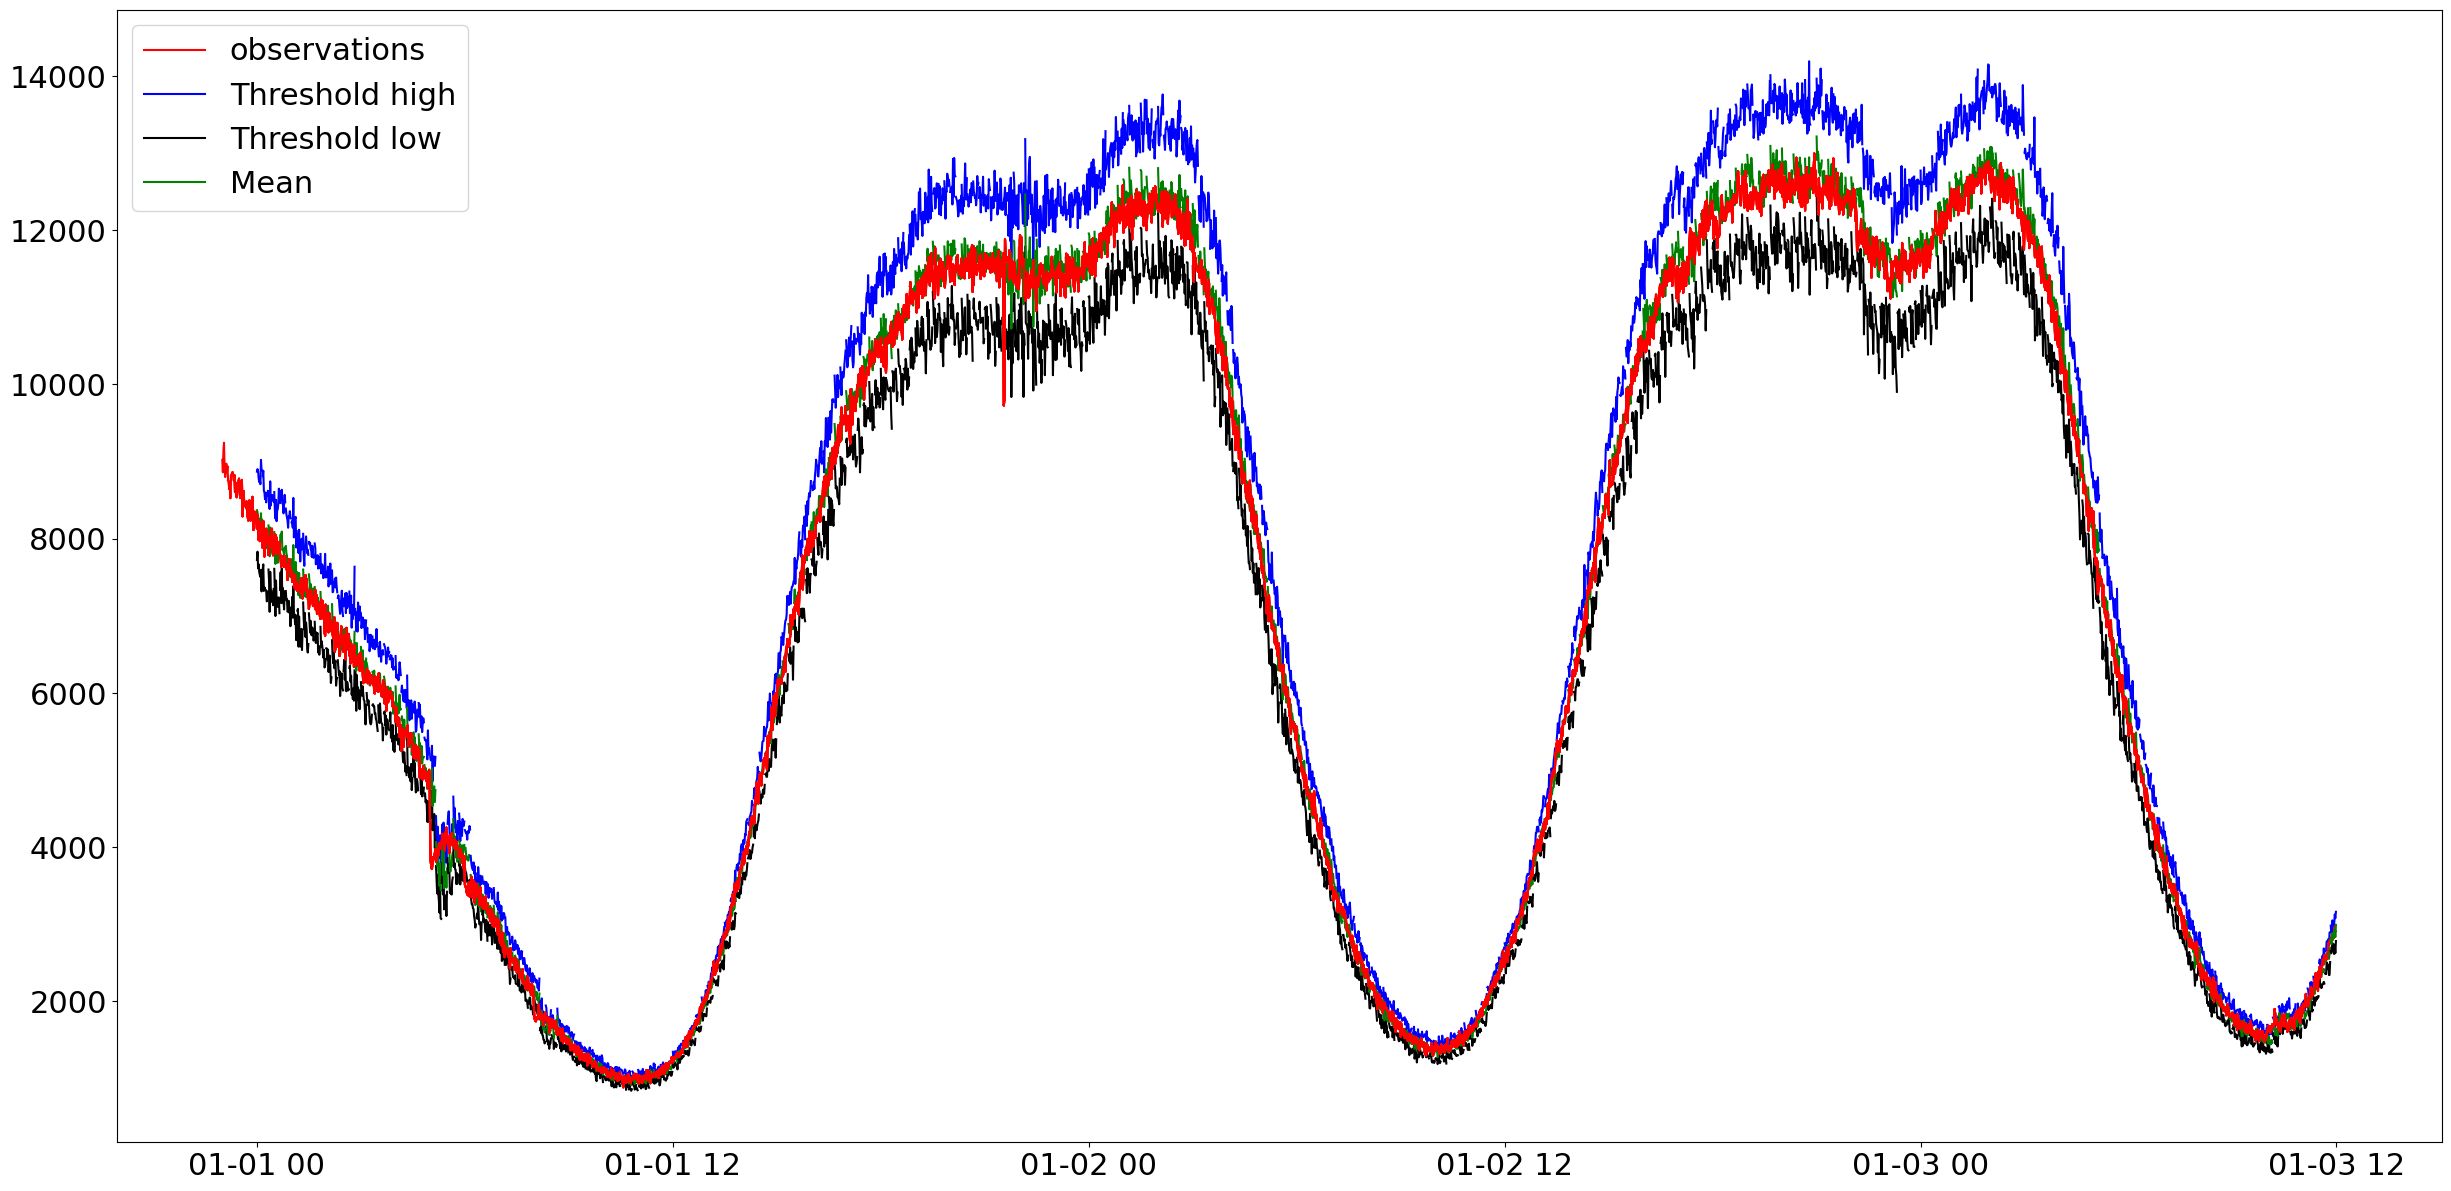

In [148]:
fig_10, ax_10 = plt.subplots(1, 1)

def plot_prob_forecasts_10(recur, ts_entry, forecast_entry):
    plot_length = 60+10
#     prediction_intervals = (50.0,98.0)
#     legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    prediction_intervals = [98.0]
#     legend = ["observations", "median prediction"] + [f"{prediction_intervals[0]}% prediction interval"]
    legend = ["observations", "Threshold high", "Threshold low", "Mean"]
#     fig, ax = plt.subplots(1, 1)
#     ts_entry[-plot_length:].plot(ax=ax, color='r')  # plot the time series
    ax_10.plot(ts_entry, color='r', label='observations')
#     print(ts_entry)
#     forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax_10.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.98), color='b', label='Threshold high')
    ax_10.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.quantile(0.02), color='black', label='Threshold low')
    ax_10.plot(d.timestamps[701280-60*1+10*recur+60*1:701280-60*1+10*recur+60*1+10], forecast_entry.mean, color='g', label='Mean')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")

peakover_10 = []
peakbelow_10 = []
threshold_over_10 = []
threshold_below_10 = []
mean_10 = []
    
for recur_10 in range(360):
    test_ds_10 = mk_ds(d[701280-60*1+10*recur_10:701280-60*1+10*recur_10+60*1+10]) #End: 1347422

    forecast_it_10, ts_it_10 = make_evaluation_predictions(
        dataset=test_ds_10,  # test dataset
        predictor=predictor_10,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts_10 = list(forecast_it_10)
    tss_10 = list(ts_it_10)

    # first entry of the time series list
    ts_entry_10 = tss_10[0]

    # first entry of test_ds
    test_ds_entry_10 = next(iter(test_ds_10))

    # first entry of the forecast list
    forecast_entry_10 = forecasts_10[0]
    
    #Compute the threshold above and below the series, and compute the extreme values
    threshold_over_10.extend(forecast_entry_10.quantile(0.98))
    threshold_below_10.extend(forecast_entry_10.quantile(0.02))
    mean_10.extend(forecast_entry_10.mean)
#     print(ts_entry_10)
#     print(len(ts_entry_10))
    for i_10 in range(len(forecast_entry_10.quantile(0.98))):
        threshold_high_10 = (forecast_entry_10.quantile(0.98))[i_10]
        threshold_low_10 = (forecast_entry_10.quantile(0.02))[i_10]
        peakover_10.append(ts_entry_10[0][60+i_10] - threshold_high_10 if ts_entry_10[0][60+i_10] - threshold_high_10 >= 0 else np.nan)
        peakbelow_10.append(threshold_low_10 - ts_entry_10[0][60+i_10] if ts_entry_10[0][60+i_10] - threshold_low_10 <= 0 else np.nan)

    plot_prob_forecasts_10(recur_10, ts_entry_10, forecast_entry_10)

plt.show()

In [ ]:
xxxxx

In [ ]:
def draw_trend(timeseries, size):
    f = plt.figure(facecolor='white')
    rol_mean = timeseries.rolling(window=size).mean()
    rol_std = timeseries.rolling(window=size).std()
    dSeriesNew['rol_mean'] = rol_mean
    dSeriesNew['rol_std'] = rol_std
 
    timeseries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_std.plot(color='black', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

def draw_ts(timeseries):
    f = plt.figure(facecolor='white')
    timeseries.plot(color='blue')
    plt.show()

dSeries = pd.Series((v for v in d.ts), index=(time for time in d.timestamps))
dSeriesNew = pd.Series((v for v in d.ts), index=(time for time in d.timestamps))
draw_trend(dSeries,12)

In [ ]:
dSeriesNew

In [ ]:
xxxxx

In [ ]:
usecols = ['forecast_date', 'horizon', 'score', 'mean', 'stderr', 'dof', 'actuals']

scores = pd.read_csv(
    'score_df.csv',
    usecols=usecols)

scores.drop_duplicates(inplace=True)
scores['forecast_date'] = pd.to_datetime(scores['forecast_date'])

scores = scores[scores.horizon==1].drop('horizon', axis=1)
scores = scores.set_index('forecast_date', drop=True)

In [ ]:
# progress bar
from tqdm import tqdm, tqdm_notebook
# instantiate
tqdm.pandas(tqdm_notebook)


def get_threshold(x, q):
    threshold = sp.stats.t.ppf(q=[1-q, q], df=x['dof'], loc=x['mean'], scale=x['stderr'])

    peakover = x['actuals'] - threshold[1] if x['actuals'] - threshold[1] >= 0 else np.nan     
    peakbelow = threshold[0] - x['actuals'] if x['actuals'] - threshold[0] <= 0 else np.nan     
    
    return pd.Series([threshold[1], peakover, threshold[0], peakbelow],
                     index=['threshold_over', 'peak_over', 'threshold_below', 'peak_below'])

# Upper threshold 
q=0.98

# Constructing peak-over and below threshold.
scores[['threshold_over', 'peak_over',
        'threshold_below', 'peak_below']] = scores.progress_apply(get_threshold, axis=1, q=q)
scores.head()

In [ ]:
def plot_peaks(df):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    peakover = df['threshold_over'] + df['peak_over']
    peakbelow = df['threshold_below'] - df['peak_below']
    
    ax.plot(df['actuals'], label='Actuals')
    ax.plot(df['threshold_over'], color='r', label='Threshold high')
    ax.plot(df['threshold_below'], color='g', label='Threshold low')
    
    ax.plot(peakover, marker='o', color='r', linestyle = 'None', label='Over threshold', markersize = 12)
    ax.plot(peakbelow, marker='o', color='g', linestyle = 'None', label='Below threshold', markersize = 12)
    
    ax.legend()

    
plot_peaks(scores.loc['2019-04-14 12:00:00':'2019-04-14 23:59:00'])

In [ ]:
def plot_peakbelow(df):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)

    ax.plot(df['peak_below'], marker='o', color='g', linestyle = 'None', label='Peaks below threshold')
    #ax.plot(df['peak_over'], marker='o', color='r', linestyle = 'None', label='Peaks over threshold')
    ax.legend()

plot_peakbelow(scores.loc['2019-04-14 12:00:00':'2019-04-14 23:59:00'])

In [ ]:
plot_peaks(scores.loc['2019-01-01 00:00:00':'2019-01-31 23:59:00'])

In [ ]:
plot_peakbelow(scores.loc['2019-01-01 00:00:00':'2019-01-31 23:59:00'])

In [ ]:
scores.plot.scatter(x='peak_below', y='mean', figsize=(18.5, 10.5))

In [ ]:
peak_df = scores[['actuals', 'score', 'mean', 'stderr', 'dof', 'peak_below', 'threshold_below']]

peak_df['hour'] = peak_df.index.hour
peak_df['dayofweek'] = peak_df.index.dayofweek
peak_df['weekofyear'] = peak_df.index.weekofyear
peak_df['month'] = peak_df.index.month

In [ ]:
def mk_ds(df):
    feat_dynamic_cat = np.vstack([df.hour.values, df.dayofweek.values, df.month.values])
    feat_dynamic_real = np.vstack([df['mean'].values]) # , df.stderr.values, df.dof.values 
    
    target = df.peak_below.values
    observed = [0 if np.isnan(x) else 1 for x in target]
    
    ds = ListDataset([{
        'feat_dynamic_cat': feat_dynamic_cat,
        'feat_dynamic_real': feat_dynamic_real,
        'target': [0 if np.isnan(x) else x for x in target],
        'start': '2019-01-01 00:00:00',
        'observed_values': observed
                      }],
        freq='1min'
    )
    return ds
    
    
train_ds = mk_ds(peak_df.tail(-1000).dropna()) # note the dropna!
test_df = peak_df.tail(10000).dropna() 
test_ds = mk_ds(test_df) 

test_df